<a href="https://colab.research.google.com/github/huangjianxiangzju/CS224W_GNN/blob/main/Copy_of_AlphaFold_multistate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/huhlim/alphafold-multistate/blob/main/AlphaFold_multistate.ipynb)

#Multi-state modeling of the GPCR and kinase using AlphaFold2
It is a modified version of multi-state modeling protocol for the GPCR and kinase using the [ColabFold](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb) interface. The original protocol utlizes [AlphaFold2](https://www.nature.com/articles/s41586-021-03819-2) and slightly modified to model multiple states of the GPCR and kinase. Modeling is guided by templates selected from activation state-annotated GPCR databases or conformational state-annotated kinase databases. The state annotations were taken from [GPCRdb](https://gpcrdb.org/structure/) for the GPCR and [KinCoRe](http://dunbrack.fccc.edu/kincore/home) for the kinase. To effectively use structural template-based features, MSA-based features are further modified. For details, please check [our manuscript](https://www.biorxiv.org/content/10.1101/2021.11.26.470086v2) and [our GitHub repository](https://github.com/huhlim/alphafold-multistate).



In [114]:
#@title Input protein sequence, then hit `Runtime` -> `Run all`
from google.colab import files
import os.path
import re
import hashlib

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

#seq={'6OSA': 'MRLNSSAPGTPGTPAADPFQRAQAGLEEALLAPGFGNASGNASERVLAAPSSELDVNTDIYSKVLVTAVYLALFVVGTVGNTVTAFTLARKKSLQSLQSTVHYHLGSLALSDLLTLLLAMPVELYNFIWVHHPWAFGDAGCRGYYFLRDACTYATALNVASLSVERYLAICHPFKAKTLMSRSRTKKFISAIWLASALLAVPMLFTMGEQNRSADGQHAGGLVCTPTIHTATVKVVIQVNTFMSFIFPMVVISVLNTIIANKLTVMVRQAAEQGQVCTVGGEHSTFSMAIEPGRVQALRHGVRVLRAVVIAFVVCWLPYHVRRLMFCYISDEQWTPFLYDFYHYFYMVTNALFYVSSTINPILYNLVSANFRHIFLATLACLCPVWRRRRKRPAFSRKADSVSSNHTLSSNATRETLY', '7E2X': 'MDVLSPGQGNNTTSPPAPFETGGNTTGISDVTVSYQVITSLLLGTLIFCAVLGNACVVAAIALERSLQNVANYLIGSLAVTDLMVSVLVLPMAALYQVLNKWTLGQVTCDLFIALDVLCCTSSILHLCAIALDRYWAITDPIDYVNKRTPRRAAALISLTWLIGFLISIPPMLGWRTPEDRSDPDACTISKDHGYTIYSTFGAFYIPLLLMLVLYGRIFRAARFRIRKTVKKVEKTGADTRHGASPAPQPKKSVNGESGSRNWRLGVESKAGGALCANGAVRQGDDGAALEVIEVHRVGNSKEHLPLPSEAGPTPCAPASFERKNERNAEAKRKMALARERKTVKTLGIIMGTFILCWLPFFIVALVLPFCESSCHMPTLLGAIINWLGYSNSLLNPVIYAYFNKDFQNAFKKIIKCKFCRQ', '7E33': 'MNITNCTTEASMAIRPKTITEKMLICMTLVVITTLTTLLNLAVIMAIGTTKKLHQPANYLICSLAVTDLLVAVLVMPLSIIYIVMDRWKLGYFLCEVWLSVDMTCCTCSILHLCVIALDRYWAITNAIEYARKRTAKRAALMILTVWTISIFISMPPLFWRSHRRLSPPPSQCTIQHDHVIYTIYSTLGAFYIPLTLILILYYRIYHAAKSLYQKRGSSRHLSNRSTDSQNSFASCKLTQTFCVSDFSTSDPTTEFEKFHASIRIPPFDNDLDHPGERQQISSTRERKAARILGLILGAFILSWLPFFIKELIVGLSIYTVSSEVADFLTWLGYVNSLINPLLYTSFNEDFKLAFKKLIRCREHT', '7EXD': 'MDFLNSSDQNLTSEELLNRMPSKILVSLTLSGLALMTTTINSLVIAAIIVTRKLHHPANYLICSLAVTDFLVAVLVMPFSIVYIVRESWIMGQVVCDIWLSVDITCCTCSILHLSAIALDRYRAITDAVEYARKRTPKHAGIMITIVWIISVFISMPPLFWRHQGTSRDDECIIKHDHIVSTIYSTFGAFYIPLALILILYYKIYRAAKTLYHKRQASRIAKEEVNGQVLLESGEKSTKSVSTSYVLEKSLSDPSTDFDKIHSTVRSLRSEFKHEKSWRRQKISGTRERKAATTLGLILGAFVICWLPFFVKELVVNVCDKCKISEEMSNFLAWLGYLNSLINPLIYTIFNEDFKKAFQKLVRCRC', '7F1Q': 'MDYQVSSPIYDINYYTSEPCQKINVKQIAARLLPPLYSLVFIFGFVGNMLVILILINCKRLKSMTDIYLLNLAISDLFFLLTVPFWAHYAAAQWDFGNTMCQLLTGLYFIGFFSGIFFIILLTIDRYLAVVHAVFALKARTVTFGVVTSVITWVVAVFASLPGIIFTRSQKEGLHYTCSSHFPYSQYQFWKNFQTLKIVILGLVLPLLVMVICYSGILKTLLRCRNEKKRHRAVRLIFTIMIVYFLFWAPYNIVLLLNTFQEFFGLNNCSSSNRLDQAMQVTETLGMTHCCINPIIYAFVGEKFRNYLLVFFQKHIAKRFCKCCSIFQQEAPERASSVYTRSTGEQEISVGL', '7JVR': 'MDPLNLSWYDDDLERQNWSRPFNGSDGKADRPHYNYYATLLTLLIAVIVFGNVLVCMAVSREKALQTTTNYLIVSLAVADLLVATLVMPWVVYLEVVGEWKFSRIHCDIFVTLDVMMCTASILNLCAISIDRYTAVAMPMLYNTRYSSKRRVTVMISIVWVLSFTISCPLLFGLNNADQNECIIANPAFVVYSSIVSFYVPFIVTLLVYIKIYIVLRRRRKRVNTKRSSRAFRAHLRAPLKGNCTHPEDMKLCTVIMKSNGSFPVNRRRVEAARRAQELEMEMLSSTSPPERTRYSPIPPSHHQLTLPDPSHHGLHSTPDSPAKPEKNGHAKDHPKIAKIFEIQTMPNGKTRTSLKTMSRRKLSQQKEKKATQMLAIVLGVFIICWLPFFITHILNIHCDCNIPPVLYSAFTWLGYVNSAVNPIIYTTFNIEFRKAFLKILHC', '7SQO': 'MSGTKLEDSPPCRNWSSASELNETQEPFLNPTDYDDEEFLRYLWREYLHPKEYEWVLIAGYIIVFVVALIGNVLVCVAVWKNHHMRTVTNYFIVNLSLADVLVTITCLPATLVVDITETWFFGQSLCKVIPYLQTVSVSVSVLTLSCIALDRWYAICHPLMFKSTAKRARNSIVIIWIVSCIIMIPQAIVMECSTVFPGLANKTTLFTVCDERWGGEIYPKMYHICFFLVTYMAPLCLMVLAYLQIFRKLWCRQIPGTSSVVQRKWKPLQPVSQPRGPGQPTKSRMSAVAAEIKQIRARRKTARMLMIVLLVFAICYLPISILNVLKRVFGMFAHTEDRETVYAWFTFSHWLVYANSAANPIIYNFLSGKFREEFKAAFSCCCLGVHHRQEDRLTRGRTSTESRKSLTTQISNFDNISKLSEQVVLTSISTLPAANGAGPLQNW', '7T96': 'MNNSTNSSNNSLALTSPYKTFEVVFIVLVAGSLSLVTIIGNILVMVSIKVNRHLQTVNNYFLFSLACADLIIGVFSMNLYTLYTVIGYWPLGPVVCDLWLALDYVVSNASVMNLLIISFDRYFCVTKPLTYPVKRTTKMAGMMIAAAWVLSFILWAPAILFWQFIVGVRTVEDGECYIQFFSNAAVTFGTAIAAFYLPVIIMTVLYWHISRASKSRIKKDKKEPVANQDPVSPSLVQGRIVKPNNNNMPSSDDGLEHNKIQNGKAPRDPVTENCVQGEEKESSNDSTSVSAVASNMRDDEITQDENTVSTSLGHSKDENSKQTCIRIGTKTPKSDSCTPTNTTVEVVGSSGQNGDEKQNIVARKIVKMTKQPAKKKPPPSREKKVTRTILAILLAFIITWAPYNVMVLINTFCAPCIPNTVWTIGYWLCYINSTINPACYALCNATFKKTFKHLLMCHYKNIGATR', '7VDL': 'MDPTTPAWGTESTTVNGNDQALLLLCGKETLIPVFLILFIALVGLVGNGFVLWLLGFRMRRNAFSVYVLSLAGADFLFLCFQIINCLVYLSNFFCSISINFPSFFTTVMTCAYLAGLSMLSTVSTERCLSVLWPIWYRCRRPRHLSAVVCVLLWALSLLLSILEGKFCGFLFSDGDSGWCQTFDFITAAWLIFLFMVLCGSSLALLVRILCGSRGLPLTRLYLTILLTVLVFLLCGLPFGIQWFLILWIWKDSDVLFCHIHPVSVVLSSLNSSANPIIYFFVGSFRKQWRLQQPILKLALQRALQDIAEVDHSEGCFRQGTPEMSRSSLV', '7W0N': 'MEEGGDFDNYYGADNQSECEYTDWKSSGALIPAIYMLVFLLGTTGNGLVLWTVFRSSREKRRSADIFIASLAVADLTFVVTLPLWATYTYRDYDWPFGTFFCKLSSYLIFVNMYASVFCLTGLSFDRYLAIVRPVANARLRLRVSGAVATAVLWVLAALLAMPVMVLRTTGDLENTTKVQCYMDYSMVATVSSEWAWEVGLGVSSTTVGFVVPFTIMLTCYFFIAQTIAGHFRKERIEGLRKRRRLLSIIVVLVVTFALCWMPYHLVKTLYMLGSLLHWPCDFDLFLMNIFPYCTCISYVNSCLNPFLYAFFDPRFRQACTSMLCCGQSRCAGTSHSSSGEKSASYSSGHSQGPGPNMGKGGEQMHEKSIPYSQETLVVD', '7WV9': 'MKSILDGLADTTFRTITTDLLYVGSNDIQYEDIKGDMASKLGYFPQKFPLTSFRGSPFQEKMTAGDNPQLVPADQVNITEFYNKSLSSFKENEENIQCGENFMDIECFMVLNPSQQLAIAVLSLTLGTFTVLENLLVLCVILHSRSLRCRPSYHFIGSLAVADLLGSVIFVYSFIDFHVFHRKDSRNVFLFKLGGVTASFTASVGSLFLTAIDRYISIHRPLAYKRIVTRPKAVVAFCLMWTIAIVIAVLPLLGWNCEKLQSVCSDIFPHIDETYLMFWIGVTSVLLLFIVYAYMYILWKAHSHAVRMIQRGTQKSIIIHTSEDGKVQVTRPDQARMDIRLAKTLVLILVVLIICWGPLLAIMVYDVFGKMNKLIKTVFAFCSMLCLLNSTVNPIIYALRSKDLRHAFRSMFPSCEGTAQPLDNSMGDSDCLHKHANNAASVHRAAESCIKSTVKIAKVTMSVSTDTSAEAL', '7XA3': 'MLSTSRSRFIRNTNESGEEVTTFFDYDYGAPCHKFDVKQIGAQLLPPLYSLVFIFGFVGNMLVVLILINCKKLKCLTDIYLLNLAISDLLFLITLPLWAHSAANEWVFGNAMCKLFTGLYHIGYFGGIFFIILLTIDRYLAIVHAVFALKARTVTFGVVTSVITWLVAVFASVPGIIFTKCQKEDSVYVCGPYFPRGWNNFHTIMRNILGLVLPLLIMVICYSGILKTLLRCRNEKKRHRAVRVIFTIMIVYFLFWTPYNIVILLNTFQEFFGLSNCESTSQLDQATQVTETLGMTHCCINPIIYAFVGEKFRSLFHIALGCRIAPLQKPVCGGPGVRPGKNVKVTTQGLLDGRGKGKSIGRAPEASLQDKEGA', '7XK2': 'MNRHHLQDHFLEIDKKNCCVFRDDFIVKVLPPVLGLEFIFGLLGNGLALWIFCFHLKSWKSSRIFLFNLAVADFLLIICLPFLMDNYVRRWDWKFGDIPCRLMLFMLAMNRQGSIIFLTVVAVDRYFRVVHPHHALNKISNRTAAIISCLLWGITIGLTVHLLKKKMPIQNGGANLCSSFSICHTFQWHEAMFLLEFFLPLGIILFCSARIIWSLRQRQMDRHAKIKRAITFIMVVAIVFVICFLPSVVVRIRIFWLLHTSGTQNCEVYRSVDLAFFITLSFTYMNSMLDPVVYYFSSPSFPNFFSTLINRCLQRKMTGEPDNNRSTSVELTGDPNKTRGAPEALMANSGEPWSPSYLGPTSP', '7XMS': 'MSAPSTLPPGGEEGLGTAWPSAANASSAPAEAEEAVAGPGDARAAGMVAIQCIYALVCLVGLVGNALVIFVILRYAKMKTATNIYLLNLAVADELFMLSVPFVASSAALRHWPFGSVLCRAVLSVDGLNMFTSVFCLTVLSVDRYVAVVHPLRAATYRRPSVAKLINLGVWLASLLVTLPIAIFADTRPARGGQAVACNLQWPHPAWSAVFVVYTFLLGFLLPVLAIGLCYLLIVGKMRAVALRAGWQQRRRSEKKITRLVLMVVVVFVLCWMPFYVVQLLNLFVTSLDATVNHVSLILSYANSCANPILYGFLSDNFRRFFQRVLCLRCCLLEGAGGAEEEPLDYYATALKSKGGAGCMCPPLPCQQEALQPEPGRKRIPLTRTTTF', '7Y12': 'MNQTLNSSGTVESALNYSRGSTVHTAYLVLSSLAMFTCLCGMAGNSMVIWLLGFRMHRNPFCIYILNLAAADLLFLFSMASTLSLETQPLVNTTDKVHELMKRLMYFAYTVGLSLLTAISTQRCLSVLFPIWFKCHRPRHLSAWVCGLLWTLCLLMNGLTSSFCSKFLKFNEDRCFRVDMVQAALIMGVLTPVMTLSSLTLFVWVRRSSQQWRRQPTRLFVVVLASVLVFLICSLPLSIYWFVLYWLSLPPEMQVLCFSLSRLSSSVSSSANPVIYFLVGSRRSHRLPTRSLGTVLQQALREEPELEGGETPTVGTNEMGA', '7YJ4': 'MPTLNTSASPPTFFWANASGGSVLSADDAPMPVKFLALRLMVALAYGLVGAIGLLGNLAVLWVLSNCARRAPGPPSDTFVFNLALADLGLALTLPFWAAESALDFHWPFGGALCKMVLTATVLNVYASIFLITALSVARYWVVAMAAGPGTHLSLFWARIATLAVWAAAALVTVPTAVFGVEGEVCGVRLCLLRFPSRYWLGAYQLQRVVLAFMVPLGVITTSYLLLLAFLQRRQRRRQDSRVVARSVRILVASFFLCWFPNHVVTLWGVLVKFDLVPWNSTFYTIQTYVFPVTTCLAHSNSCLNPVLYCLLRREPRQALAGTFRDLRLRLWPQGGGWVQQVALKQVGRRWVASNPRESRPSTLLTNLDRGTPG', '7YU8': 'MAAISTSIPVISQPQFTAMNEPQCFYNESIAFFYNRSGKHLATEWNTVSKLVMGLGITVCIFIMLANLLVMVAIYVNRRFHFPIYYLMANLAAADFFAGLAYFYLMFNTGPNTRRLTVSTWLLRQGLIDTSLTASVANLLAIAIERHITVFRMQLHTRMSNRRVVVVIVVIWTMAIVMGAIPSVGWNCICDIENCSNMAPLYSDSYLVFWAIFNLVTFVVMVVLYAHIFGYVRQRTMRMSRHSSGPRRNRDTMMSLLKTVVIVLGAFIICWTPGLVLLLLDVCCPQCDVLAYEKFFLLLAEFNSAMNPIIYSYRDKEMSATFRQILCCQRSENPTGPTEGSDRSASSLNHTILAGVHSNDHSVV', '8EFO': 'MDSSAAPTNASNCTDALAYSSCSPAPSPGSWVNLSHLDGNLSDPCGPNRTDLGGRDSLCPPTGSPSMITAITIMALYSIVCVVGLFGNFLVMYVIVRYTKMKTATNIYIFNLALADALATSTLPFQSVNYLMGTWPFGTILCKIVISIDYYNMFTSIFTLCTMSVDRYIAVCHPVKALDFRTPRNAKIINVCNWILSSAIGLPVMFMATTKYRQGSIDCTLTFSHPTWYWENLLKICVFIFAFIMPVLIITVCYGLMILRLKSVRMLSGSKEKDRNLRRITRMVLVVVAVFIVCWTPIHIYVIIKALVTIPETTFQTVSWHFCIALGYTNSCLNPVLYAFLDENFKRCFREFCIPTSSNIEQQNSTRIRQNTRDHPSTANTVDRTNHQLENLEAETAPLP', '8HS3': 'MPSVSPAGPSAGAVPNATAVTTVRTNASGLEVPLFHLFARLDEELHGTFPGLWLALMAVHGAIFLAGLVLNGLALYVFCCRTRAKTPSVIYTINLVVTDLLVGLSLPTRFAVYYGARGCLRCAFPHVLGYFLNMHCSILFLTCICVDRYLAIVRPEGSRRCRQPACARAVCAFVWLAAGAVTLSVLGVTGSRPCCRVFALTVLEFLLPLLVISVFTGRIMCALSRPGLLHQGRQRRVRAMQLLLTVLIIFLVCFTPFHARQVAVALWPDMPHHTSLVVYHVAVTLSSLNSCMDPIVYCFVTSGFQATVRGLFGQHGEREPSSGDVVSMHRSSKGSGRHHILSAGPHALTQALANGPEA', '8J18': 'MWNSSDANFSCYHESVLGYRYVAVSWGVVVAVTGTVGNVLTLLALAIQPKLRTRFNLLIANLTLADLLYCTLLQPFSVDTYLHLHWRTGATFCRVFGLLLFASNSVSILTLCLIALGRYLLIAHPKLFPQVFSAKGIVLALVSTWVVGVASFAPLWPIYILVPVVCTCSFDRIRGRPYTTILMGIYFVLGLSSVGIFYCLIHRQVKRAAQALDQYKLRQASIHSNHVARTDEAMPGRFQELDSRLASGGPSEGISSEPVSAATTQTLEGDSSEVGDQINSKRAKQMAEKSPPEASAKAQPIKGARRAPDSSSEFGKVTRMCFAVFLCFALSYIPFLLLNILDARVQAPRVVHMLAANLTWLNGCINPVLYAAMNRQFRQAYGSILKRGPRSFHRLH', '6K42': 'MDHQDPYSVQATAAIAAAITFLILFTIFGNALVILAVLTSRSLRAPQNLFLVSLAAADILVATLIIPFSLANELLGYWYFRRTWCEVYLALDVLFCTSSIVHLCAISLDRYWAVSRALEYNSKRTPRRIKCIILTVWLIAAVISLPPLIYKGDQGPQPRGRPQCKLNQEAWYILASSIGSFFAPCLIMILVYLRIYLIAKRSNRRGPRAKGGPGQGESKQPRPDHGGALASAKLPALASVASAREVNGHSKSTGEKEEGETPEDTGTRALPPSWAALPNSGQGQKEGVCGASPEDEAEEEEEEEEEEEECEPQAVPVSPASACSPPLQQPQGSRVLATLRGQVLLGRGVGAIGGQWWRRRAQLTREKRFTFVLAVVIGVFVLCWFPFFFSYSLGAICPKHCKVPHGLFQFFFWIGYCNSSLNPVIYTIFNQDFRRAFRRILCRPWTQTAW', '7CMV': 'MASLSQLSGHLNYTCGAENSTGASQARPHAYYALSYCALILAIVFGNGLVCMAVLKERALQTTTNYLVVSLAVADLLVATLVMPWVVYLEVTGGVWNFSRICCDVFVTLDVMMCTASILNLCAISIDRYTAVVMPVHYQHGTGQSSCRRVALMITAVWVLAFAVSCPLLFGFNTTGDPTVCSISNPDFVIYSSVVSFYLPFGVTVLVYARIYVVLKQRRRKRILTRQNSQCNSVRPGFPQQTLSPDPAHLELKRYYSICQDTALGGPGFQERGGELKREEKTRNSLSPTIAPKLSLEVRKLSNGRLSTSLKLGPLQPRGVPLREKKATQMVAIVLGAFIVCWLPFFLTHVLNTHCQTCHVSPELYSATTWLGYVNSALNPVIYTTFNIEFRKAFLKILSC', '7E32': 'MSPLNQSAEGLPQEASNRSLNATETSEAWDPRTLQALKISLAVVLSVITLATVLSNAFVLTTILLTRKLHTPANYLIGSLATTDLLVSILVMPISIAYTITHTWNFGQILCDIWLSSDITCCTASILHLCVIALDRYWAITDALEYSKRRTAGHAATMIAIVWAISICISIPPLFWRQAKAQEEMSDCLVNTSQISYTIYSTCGAFYIPSVLLIILYGRIYRAARNRILNPPSLYGKRFTTAHLITGSAGSSLCSLNSSLHEGHSHSAGSPLFFNHVKIKLADSALERKRISAARERKATKILGIILGAFIICWLPFFVVSLVLPICRDSCWIHPALFDFFTWLGYLNSLINPIIYTVFNEEFRQAFQKIVPFRKAS', '7EJX': 'MTNSSSTSTSSTTGGSLLLLCEEEESWAGRRIPVSLLYSGLAIGGTLANGMVIYLVSSFRKLQTTSNAFIVNGCAADLSVCALWMPQEAVLGLLPTGSAEPPADWDGAGGSYRLLRGGLLGLGLTVSLLSHCLVALNRYLLITRAPATYQALYQRRHTAGMLALSWALALGLVLLLPPWAPRPGAAPPRVHYPALLAAAALLAQTALLLHCYLGIVRRVRVSVKRVSVLNFHLLHQLPGCAAAAAAFPGAQHAPGPGGAAHPAQAQPLPPALHPRRAQRRLSGLSVLLLCCVFLLATQPLVWVSLASGFSLPVPWGVQAASWLLCCALSALNPLLYTWRNEEFRRSVRSVLPGVGDAAAAAVAATAVPAVSQAQLGTRAAGQHW', '7EZH': 'MDVVDSLLVNGSNITPPCELGLENETLFCLDQPRPSKEWQPAVQILLYSLIFLLSVLGNTLVITVLIRNKRMRTVTNIFLLSLAVSDLMLCLFCMPFNLIPNLLKDFIFGSAVCKTTTYFMGTSVSVSTFNLVAISLERYGAICKPLQSRVWQTKSHALKVIAATWCLSFTIMTPYPIYSNLVPFTKNNNQTANMCRFLLPNDVMQQSWHTFLLLILFLIPGIVMMVAYGLISLELYQGIKFEASQKKSAKERKPSTTSSGKYEDSDGCYLQKTRPPRKLELRQLSTGSSSRANRIRSNSSAANLMAKKRVIRMLIVIVVLFFLCWMPIFSANAWRAYDTASAERRLSGTPISFILLLSYTSSCVNPIIYCFMNKRFRLGFMATFPCCPNPGPPGARGEVGEEEEGGTTGASLSRFSYSHMSASVPPQ', '7F8V': 'MELLKLNRSVQGTGPGPGASLCRPGAPLLNSSSVGNLSCEPPRIRGAGTRELELAIRITLYAVIFLMSVGGNMLIIVVLGLSRRLRTVTNAFLLSLAVSDLLLAVACMPFTLLPNLMGTFIFGTVICKAVSYLMGVSVSVSTLSLVAIALERYSAICRPLQARVWQTRSHAARVIVATWLLSGLLMVPYPVYTVVQPVGPRVLQCVHRWPSARVRQTWSVLLLLLLFFIPGVVMAVAYGLISRELYLGLRFDGDSDSDSQSRVRNQGGLPGAVHQNGRCRPETGAVGEDSDGCYVQLPRSRPALELTALTAPGPGSGSRPTQAKLLAKKRVVRMLLVIVVLFFLCWLPVYSANTWRAFDGPGAHRALSGAPISFIHLLSYASACVNPLVYCFMHRRFRQACLETCARCCPRPPRARPRALPDEDPPTPSIASLSRLSYTTISTLGPG', '7QVM': 'MEGALAANWSAEAANASAAPPGAEGNRTAGPPRRNEALARVEVAVLCLILLLALSGNACVLLALRTTRQKHSRLFFFMKHLSIADLVVAVFQVLPQLLWDITFRFYGPDLLCRLVKYLQVVGMFASTYLLLLMSLDRCLAICQPLRSLRRRTDRLAVLATWLGCLVASAPQVHIFSLREVADGVFDCWAVFIQPWGPKAYITWITLAVYIVPVIVLAACYGLISFKIWQNLRLKTAAAAAAEAPEGAAAGDGGRVALARVSSVKLISKAKIRTVKMTFIIVLAFIVCWTPFFFVQMWSVWDANAPKEASAFIIVMLLASLNSCCNPWIYMLFTGHLFHELVQRFLCCSASYLKGRRLGETSASKKSNSSSFVLSHRSSSQRSCSQPSTA', '7T10': 'MDMADEPLNGSHTWLSIPFDLNGSVVSTNTSNQTEPYYDLTSNAVLTFIYFVVCIIGLCGNTLVIYVILRYAKMKTITNIYILNLAIADELFMLGLPFLAMQVALVHWPFGKAICRVVMTVDGINQFTSIFCLTVMSIDRYLAVVHPIKSAKWRRPRTAKMITMAVWGVSLLVILPIMIYAGLRSNQWGRSSCTINWPGESGAWYTGFIIYTFILGFLVPLTIICLCYLFIIIKVKSSGIRVGSSKRKKSEKKVTRMVSIVVAVFIFCWLPFYIFNVSSVSMAISPTPALKGMFDFVVVLTYANSCANPILYAFLSDNFKKSFQNVLCLVKVSGTDDGERSDSKQDKSRLNETTETQRTLLNGDLQTSI', '7V68': 'MANFTPVNGSSGNQSVRLVTSSSHNRYETVEMVFIATVTGSLSLVTVVGNILVMLSIKVNRQLQTVNNYFLFSLACADLIIGAFSMNLYTVYIIKGYWPLGAVVCDLWLALDYVVSNASVMNLLIISFDRYFCVTKPLTYPARRTTKMAGLMIAAAWVLSFVLWAPAILFWQFVVGKRTVPDNQCFIQFLSNPAVTFGTAIAAFYLPVVIMTVLYIHISLASRSRVHKHRPEGPKEKKAKTLAFLKSPLMKQSVKKPPPGEAAREELRNGKLEEAPPPALPPPPRPVADKDTSNESSSGSATQNTKERPATELSTTEATTPAMPAPPLQPRALNPASRWSKIQIVTKQTGNECVTAIEIVPATPAGMRPAANVARKFASIARNQVRKKRQMAARERKVTRTIFAILLAFILTWTPYNVMVLVNTFCQSCIPDTVWSIGYWLCYVNSTINPACYALCNATFKKTFRHLLLCQYRNIGTAR', '7VL9': 'METPNTTEDYDTTTEFDYGDATPCQKVNERAFGAQLLPPLYSLVFVIGLVGNILVVLVLVQYKRLKNMTSIYLLNLAISDLLFLFTLPFWIDYKLKDDWVFGDAMCKILSGFYYTGLYSEIFFIILLTIDRYLAIVHAVFALRARTVTFGVITSIIIWALAILASMPGLYFSKTQWEFTHHTCSLHFPHESLREWKLFQALKLNLFGLVLPLLVMIICYTGIIKILLRRPNEKKSKAVRLIFVIMIIFFLFWTPYNLTILISVFQDFLFTHECEQSRHLDLAVQVTEVIAYTHCCVNPVIYAFVGERFRKYLRQLFHRRVAVHLVKWLPFLSVDRLERVSSTSPSTGEHELSAGF', '7W6P': 'MFRQEQPLAEGSFAPMGSLQPDAGNASWNGTEAPGGGARATPYSLQVTLTLVCLAGLLMLLTVFGNVLVIIAVFTSRALKAPQNLFLVSLASADILVATLVIPFSLANEVMGYWYFGKAWCEIYLALDVLFCTSSIVHLCAISLDRYWSITQAIEYNLKRTPRRIKAIIITVWVISAVISFPPLISIEKKGGGGGPQPAEPRCEINDQKWYVISSCIGSFFAPCLIMILVYVRIYQIAKRRTRVPPSRRGPDAVAAPPGGTERRPNGLGPERSAGPGGAEAEPLPTQLNGAPGEPAPAGPRDTDALDLEESSSSDHAERPPGPRRPERGPRGKGKARASQVKPGDSLPRRGPGATGIGTPAAGPGEERVGAAKASRWRGRQNREKRFTFVLAVVIGVFVVCWFPFFFTYTLTAVGCSVPRTLFKFFFWFGYCNSSLNPVIYTIFNHDFRRAFKKILCRGDRKRIV', '7X9A': 'MNSTLFSQVENHSVHSNFSEKNAQLLAFENDDCHLPLAMIFTLALAYGAVIILGVSGNLALIIIILKQKEMRNVTNILIVNLSFSDLLVAIMCLPFTFVYTLMDHWVFGEAMCKLNPFVQCVSITVSIFSLVLIAVERHQLIINPRGWRPNNRHAYVGIAVIWVLAVASSLPFLIYQVMTDEPFQNVTLDAYKDKYVCFDQFPSDSHRLSYTTLLLVLQYFGPLCFIFICYFKIYIRLKRRNNMMDKMRDNKYRSSETKRINIMLLSIVVAFAVCWLPLTIFNTVFDWNHQIIATCNHNLLFLLCHLTAMISTCVNPIFYGFLNKNFQRDLQFFFNFCDFRSRDDDYETIAMSTMHTDVSKTSLKQASPVAFKKINNNDDNEKI', '7XBX': 'MDQFPESVTENFEYDDLAEACYIGDIVVFGTVFLSIFYSVIFAIGLVGNLLVVFALTNSKKPKSVTDIYLLNLALSDLLFVATLPFWTHYLINEKGLHNAMCKFTTAFFFIGFFGSIFFITVISIDRYLAIVLAANSMNNRTVQHGVTISLGVWAAAILVAAPQFMFTKQKENECLGDYPEVLQEIWPVLRNVETNFLGFLLPLLIMSYCYFRIIQTLFSCKNHKKAKAIKLILLVVIVFFLFWTPYNVMIFLETLKLYDFFPSCDMRKDLRLALSVTETVAFSHCCLNPLIYAFAGEKFRRYLYHLYGKCLAVLCGRSVHVDFSSSESQRSRHGSVLSSNFTYHTSDGDALLLL', '7XK8': 'MSGMEKLQNASWIYQQKLEDPFQKHLNSTEEYLAFLCGPRRSHFFLPVSVVYVPIFVVGVIGNVLVCLVILQHQAMKTPTNYYLFSLAVSDLLVLLLGMPLEVYEMWRNYPFLFGPVGCYFKTALFETVCFASILSITTVSVERYVAILHPFRAKLQSTRRRALRILGIVWGFSVLFSLPNTSIHGIKFHYFPNGSLVPGSATCTVIKPMWIYNFIIQVTSFLFYLLPMTVISVLYYLMALRLKKDKSLEADEGNANIQRPCRKSVNKMLFVLVLVFAICWAPFHIDRLFFSFVEEWSESLAAVFNLVHVVSGVFFYLSSAVNPIIYNLLSRRFQAAFQNVISSFHKQWHSQHDPQLPPAQRNIFLTECHFVELTEDIGPQFPCQSSMHNSHLPAALSSEQMSRTNYQSFHFNKT', '7XTA': 'MDKLDANVSSEEGFGSVEKVVLLTFLSTVILMAILGNLLVMVAVCWDRQLRKIKTNYFIVSLAFADLLVSVLVMPFGAIELVQDIWIYGEVFCLVRTSLDVLLTTASIFHLCCISLDRYYAICCQPLVYRNKMTPLRIALMLGGCWVIPTFISFLPIMQGWNNIGIIDLIEKRKFNQNSNSTYCVFMVNKPYAITCSVVAFYIPFLLMVLAYYRIYVTAKEHAHQIQMLQRAGASSESRPQSADQHSTHRMRTETKAAKTLCIIMGCFCLCWAPFFVTNIVDPFIDYTVPGQVWTAFLWLGYINSGLNPFLYAFLNKSFRRAFLIILCCDDERYRRPSILGQTVPCSTTTINGSTHVLRDAVECGGQWESQCHPPATSPLVAAQPSDT', '7Y89': 'MSKRSWWAGSRKPPREMLKLSGSDSSQSMNGLEVAPPGLITNFSLATAEQCGQETPLENMLFASFYLLDFILALVGNTLALWLFIRDHKSGTPANVFLMHLAVADLSCVLVLPTRLVYHFSGNHWPFGEIACRLTGFLFYLNMYASIYFLTCISADRFLAIVHPVKSLKLRRPLYAHLACAFLWVVVAVAMAPLLVSPQTVQTNHTVVCLQLYREKASHHALVSLAVAFTFPFITTVTCYLLIIRSLRQGLRVEKRLKTKAVRMIAIVLAIFLVCFVPYHVNRSVYVLHYRSHGASCATQRILALANRITSCLTSLNGALDPIMYFFVAEKFRHALCNLLCGKRLKGPPPSFEGKTNESSLSAKSEL', '7YKD': 'MRMEDEDYNTSISYGDEYPDYLDSIVVLEDLSPLEARVTRIFLVVVYSIVCFLGILGNGLVIIIATFKMKKTVNMVWFLNLAVADFLFNVFLPIHITYAAMDYHWVFGTAMCKISNFLLIHNMFTSVFLLTIISSDRCISVLLPVWSQNHRSVRLAYMACMVIWVLAFFLSSPSLVFRDTANLHGKISCFNNFSLSTPGSSSWPTHSQMDPVGYSRHMVVTVTRFLCGFLVPVLIITACYLTIVCKLQRNRLAKTKKPFKIIVTIIITFFLCWCPYHTLNLLELHHTAMPGSVFSLGLPLATALAIANSCMNPILYVFMGQDFKKFKVALFSRLVNALSEDTGHSSYPSHRSFTKMSSMNERTSMNERETGML', '8DZQ': 'MDSPIQIFRGEPGPTCAPSACLPPNSSAWFPGWAEPDSNGSAGSEDAQLEPAHISPAIPVIITAVYSVVFVVGLVGNSLVMFVIIRYTKMKTATNIYIFNLALADALVTTTMPFQSTVYLMNSWPFGDVLCKIVISIDYYNMFTSIFTLTMMSVDRYIAVCHPVKALDFRTPLKAKIINICIWLLSSSVGISAIVLGGTKVREDVDVIECSLQFPDDDYSWWDLFMKICVFIFAFVIPVLIIIVCYTLMILRLKSVRLLSGSREKDRNLRRITRLVLVVVAVFVVCWTPIHIFILVEALGSTSHSTAALSSYYFCIALGYTNSSLNPILYAFLDENFKRCFRDFCFPLKMRMERQSTSRVRNTVQDPAYLRDIDGMNKPV', '8HK2': 'MASFSAETNSTDLLSQPWNEPPVILSMVILSLTFLLGLPGNGLVLWVAGLKMQRTVNTIWFLHLTLADLLCCLSLPFSLAHLALQGQWPYGRFLCKLIPSIIVLNMFASVFLLTAISLDRCLVVFKPIWCQNHRNVGMACSICGCIWVVAFVMCIPVFVYREIFTTDNHNRCGYKFGLSSSLDYPDFYGDPLENRSLENIVQPPGEMNDRLDPSSFQTNDHPWTVPTVFQPQTFQRPSADSLPRGSARLTSQNLYSNVFKPADVVSPKIPSGFPIEDHETSPLDNSDAFLSTHLKLFPSASSNSFYESELPQGFQDYYNLGQFTDDDQVPTPLVAITITRLVVGFLLPSVIMIACYSFIVFRMQRGRFAKSQSKTFRVAVVVVAVFLVCWTPYHIFGVLSLLTDPETPLGKTLMSWDHVCIALASANSCFNPFLYALLGKDFRKKARQSIQGILEAAFSEELTRSTHCPSNNVISERNSTTV', '8IC0': 'MSNITDPQMWDFDDLNFTGMPPADEDYSPCMLETETLNKYVVIIAYALVFLLSLLGNSLVMLVILYSRVGRSVTDVYLLNLALADLLFALTLPIWAASKVNGWIFGTFLCKVVSLLKEVNFYSGILLLACISVDRYLAIVHATRTLTQKRHLVKFVCLGCWGLSMNLSLPFFLFRQAYHPNNSSPVCYEVLGNDTAKWRMVLRILPHTFGFIVPLFVMLFCYGFTLRTLFKAHMGQKHRAMRVIFAVVLIFLLCWLPYNLVLLADTLMRTQVIQESCERRNNIGRALDATEILGFLHSCLNPIIYAFIGQNFRHGFLKILAMHGLVSKEFLARHRVTSYTSSSVNVSSNL', '6LML': 'MPPCQPQRPLLLLLLLLACQPQVPSAQVMDFLFEKWKLYGDQCHHNLSLLPPPTELVCNRTFDKYSCWPDTPANTTANISCPWYLPWHHKVQHRFVFKRCGPDGQWVRGPRGQPWRDASQCQMDGEEIEVQKEVAKMYSSFQVMYTVGYSLSLGALLLALAILGGLSKLHCTRNAIHANLFASFVLKASSVLVIDGLLRTRYSQKIGDDLSVSTWLSDGAVAGCRVAAVFMQYGIVANYCWLLVEGLYLHNLLGLATLPERSFFSLYLGIGWGAPMLFVVPWAVVKCLFENVQCWTSNDNMGFWWILRFPVFLAILINFFIFVRIVQLLVAKLRARQMHHTDYKFRLAKSTLTLIPLLGVHEVVFAFVTDEHAQGTLRSAKLFFDLFLSSFQGLLVAVLYCFLNKEVQSELRRRWHRWRLGKVLWEERNTSNHRASSSPGHGPPSKELQFGRGGGSQDSSAETPLAGGLPRLAESPF', '7TRY': 'MDAALLHSLLEANCSLALAEELLLDGWGPPLDPEGPYSYCNTTLDQIGTCWPRSAAGALVERPCPEYFNGVKYNTTRNAYRECLENGTWASKINYSQCEPILDDKQRKYDLHYRIALVVNYLGHCVSVAALVAAFLLFLALRSIRCLRNVIHWNLITTFILRNVMWFLLQLVDHEVHESNEVWCRCITTIFNYFVVTNFFWMFVEGCYLHTAIVMTYSTERLRKCLFLFIGWCIPFPIIVAWAIGKLYYENEQCWFGKEPGDLVDYIYQGPIILVLLINFVFLFNIVRILMTKLRASTTSETIQYRKAVKATLVLLPLLGITYMLFFVNPGEDDLSQIMFIYFNSFLQSFQGFFVSVFYCFFNGEVRSAVRKRWHRWQDHHSLRVPMARAMSIPTSPTRISFHSIKQTAAV', '6PB0': 'MGGHPQLRLVKALLLLGLNPVSASLQDQHCESLSLASNISGLQCNASVDLIGTCWPRSPAGQLVVRPCPAFFYGVRYNTTNNGYRECLANGSWAARVNYSECQEILNEEKKSKVHYHVAVIINYLGHCISLVALLVAFVLFLRLRSIRCLRNIIHWNLISAFILRNATWFVVQLTMSPEVHQSNVGWCRLVTAAYNYFHVTNFFWMFGEGCYLHTAIVLTYSTDRLRKWMFICIGWGVPFPIIVAWAIGKLYYDNEKCWFGKRPGVYTDYIYQGPMILVLLINFIFLFNIVRILMTKLRASTTSETIQYRKAVKATLVLLPLLGITYMLFFVNPGEDEVSRVVFIYFNSFLESFQGFFVSVFYCFLNSEVRSAIRKRWHRWQDKHSIRARVARAMSIPTSPTRVSFHSIKQSTAV', '6PB1': 'MDAALLHSLLEANCSLALAEELLLDGWGPPLDPEGPYSYCNTTLDQIGTCWPRSAAGALVERPCPEYFNGVKYNTTRNAYRECLENGTWASKINYSQCEPILDDKQRKYDLHYRIALVVNYLGHCVSVAALVAAFLLFLALRSIRCLRNVIHWNLITTFILRNVMWFLLQLVDHEVHESNEVWCRCITTIFNYFVVTNFFWMFVEGCYLHTAIVMTYSTERLRKCLFLFIGWCIPFPIIVAWAIGKLYYENEQCWFGKEPGDLVDYIYQGPIILVLLINFVFLFNIVRILMTKLRASTTSETIQYRKAVKATLVLLPLLGITYMLFFVNPGEDDLSQIMFIYFNSFLQSFQGFFVSVFYCFFNGEVRSAVRKRWHRWQDHHSLRVPMARAMSIPTSPTRISFHSIKQTAAV', '6UVA': 'MEKKCTLYFLVLLPFFMILVTAELEESPEDSIQLGVTRNKIMTAQYECYQKIMQDPIQQAEGVYCNRTWDGWLCWNDVAAGTESMQLCPDYFQDFDPSEKVTKICDQDGNWFRHPASNRTWTNYTQCNVNTHEKVKTALNLFYLTIIGHGLSIASLLISLGIFFYFKSLSCQRITLHKNLFFSFVCNSVVTIIHLTAVANNQALVATNPVSCKVSQFIHLYLMGCNYFWMLCEGIYLHTLIVVAVFAEKQHLMWYYFLGWGFPLIPACIHAIARSLYYNDNCWISSDTHLLYIIHGPICAALLVNLFFLLNIVRVLITKLKVTHQAESNLYMKAVRATLILVPLLGIEFVLIPWRPEGKIAEEVYDYIMHILMHFQGLLVSTIFCFFNGEVQAILRRNWNQYKIQFGNSFSNSEALRSASYTVSTISDGPGYSHDCPSEHLNGKSIHDIENVLLKPENLYN', '6WZG': 'MRPHLSPPLQQLLLPVLLACAAHSTGALPRLCDVLQVLWEEQDQCLQELSREQTGDLGTEQPVPGCEGMWDNISCWPSSVPGRMVEVECPRFLRMLTSRNGSLFRNCTQDGWSETFPRPNLACGVNVNDSSNEKRHSYLLKLKVMYTVGYSSSLVMLLVALGILCAFRRLHCTRNYIHMHLFVSFILRALSNFIKDAVLFSSDDVTYCDAHRAGCKLVMVLFQYCIMANYSWLLVEGLYLHTLLAISFFSERKYLQGFVAFGWGSPAIFVALWAIARHFLEDVGCWDINANASIWWIIRGPVILSILINFILFINILRILMRKLRTQETRGNEVSHYKRLARSTLLLIPLFGIHYIVFAFSPEDAMEIQLFFELALGSFQGLVVAVLYCFLNGEVQLEVQKKWQQWHLREFPLHPVASFSNSTKASHLEQSQGTCRTSII', '7DUQ': 'MAGAPGPLRLALLLLGMVGRAGPRPQGATVSLWETVQKWREYRRQCQRSLTEDPPPATDLFCNRTFDEYACWPDGEPGSFVNVSCPWYLPWASSVPQGHVYRFCTAEGLWLQKDNSSLPWRDLSECEESKRGERSSPEEQLLFLYIIYTVGYALSFSALVIASAILLGFRHLHCTRNYIHLNLFASFILRALSVFIKDAALKWMYSTAAQQHQWDGLLSYQDSLSCRLVFLLMQYCVAANYYWLLVEGVYLYTLLAFSVLSEQWIFRLYVSIGWGVPLLFVVPWGIVKYLYEDEGCWTRNSNMNYWLIIRLPILFAIGVNFLIFVRVICIVVSKLKANLMCKTDIKCRLAKSTLTLIPLLGTHEVIFAFVMDEHARGTLRFIKLFTELSFTSFQGLMVAILYCFVNNEVQLEFRKSWERWRLEHLHIQRDSSMKPLKCPTSSLSSGATAGSSMYTATCQASCS', '7FIN': 'MTTSPILQLLLRLSLCGLLLQRAETGSKGQTAGELYQRWERYRRECQETLAAAEPPSGLACNGSFDMYVCWDYAAPNATARASCPWYLPWHHHVAAGFVLRQCGSDGQWGLWRDHTQCENPEKNEAFLDQRLILERLQVMYTVGYSLSLATLLLALLILSLFRRLHCTRNYIHINLFTSFMLRAAAILSRDRLLPRPGPYLGDQALALWNQALAACRTAQIVTQYCVGANYTWLLVEGVYLHSLLVLVGGSEEGHFRYYLLLGWGAPALFVIPWVIVRYLYENTQCWERNEVKAIWWIIRTPILMTILINFLIFIRILGILLSKLRTRQMRCRDYRLRLARSTLTLVPLLGVHEVVFAPVTEEQARGALRFAKLGFEIFLSSFQGFLVSVLYCFINKEVQSEIRRGWHHCRLRRSLGEEQRQLPERAFRALPSGSGPGEVPTSRGLSSGTLPGPGNEASRELESYC', '7WBJ': 'MRTLLPPALLTCWLLAPVNSIHPECRFHLEIQEEETKCAELLRSQTEKHKACSGVWDNITCWRPANVGETVTVPCPKVFSNFYSKAGNISKNCTSDGWSETFPDFVDACGYSDPEDESKITFYILVKAIYTLGYSVSLMSLATGSIILCLFRKLHCTRNYIHLNLFLSFILRAISVLVKDDVLYSSSGTLHCPDQPSSWVGCKLSLVFLQYCIMANFFWLLVEGLYLHTLLVAMLPPRRCFLAYLLIGWGLPTVCIGAWTAARLYLEDTGCWDTNDHSVPWWVIRIPILISIIVNFVLFISIIRILLQKLTSPDVGGNDQSQYKRLAKSTLLLIPLFGVHYMVFAVFPISISSKYQILFELCLGSFQGLVVAVLYCFLNSEVQCELKRKWRSRCPTPSASRDYRVCGSSFSRNGSEGALQFHRGSRAQSFLQTETSVI', '8E3X': 'MAGVVHVSLAALLLLPMAPAMHSDCIFKKEQAMCLEKIQRANELMGFNDSSPGCPGMWDNITCWKPAHVGEMVLVSCPELFRIFNPDQVWETETIGESDFGDSNSLDLSDMGVVSRNCTEDGWSEPFPHYFDACGFDEYESETGDQDYYYLSVKALYTVGYSTSLVTLTTAMVILCRFRKLHCTRNFIHMNLFVSFMLRAISVFIKDWILYAEQDSNHCFISTVECKAVMVFFHYCVVSNYFWLFIEGLYLFTLLVETFFPERRYFYWYTIIGWGTPTVCVTVWATLRLYFDDTGCWDMNDSTALWWVIKGPVVGSIMVNFVLFIGIIVILVQKLQSPDMGGNESSIYLRLARSTLLLIPLFGIHYTVFAFSPENVSKRERLVFELGLGSFQGFVVAVLYCFLNGEVQAEIKRKWRSWKVNRYFAVDFKHRHPSLASSGVNGGTQLSILSKSSSQIRMSGLPADNLAT', '8E3Y': 'MRPPSPLPARWLCVLAGALAWALGPAGGQAARLQEECDYVQMIEVQHKQCLEEAQLENETIGCSKMWDNLTCWPATPRGQVVVLACPLIFKLFSSIQGRNVSRSCTDEGWTHLEPGPYPIACGLDDKAASLDEQQTMFYGSVKTGYTIGYGLSLATLLVATAILSLFRKLHCTRNYIHMHLFISFILRAAAVFIKDLALFDSGESDQCSEGSVGCKAAMVFFQYCVMANFFWLLVEGLYLYTLLAVSFFSERKYFWGYILIGWGVPSTFTMVWTIARIHFEDYGCWDTINSSLWWIIKGPILTSILVNFILFICIIRILLQKLRPPDIRKSDSSPYSRLARSTLLLIPLFGVHYIMFAFFPDNFKPEVKMVFELVVGSFQGFVVAILYCFLNGEVQAELRRKWRRWHLQGVLGWNPKYRHPSGGSNGATCSTQVSMLTRVSPGARRSSSFQAEVSLV', '8F2B': 'MRFTFTSRCLALFLLLNHPTPILPAFSNQTYPTIEPKPFLYVVGRKKMMDAQYKCYDRMQQLPAYQGEGPYCNRTWDGWLCWDDTPAGVLSYQFCPDYFPDFDPSEKVTKYCDEKGVWFKHPENNRTWSNYTMCNAFTPEKLKNAYVLYYLAIVGHSLSIFTLVISLGIFVFFRSLGCQRVTLHKNMFLTYILNSMIIIIHLVEVVPNGELVRRDPVSCKILHFFHQYMMACNYFWMLCEGIYLHTLIVVAVFTEKQRLRWYYLLGWGFPLVPTTIHAITRAVYFNDNCWLSVETHLLYIIHGPVMAALVVNFFFLLNIVRVLVTKMRETHEAESHMYLKAVKATMILVPLLGIQFVVFPWRPSNKMLGKIYDYVMHSLIHFQGFFVATIYCFCNNEVQTTVKRQWAQFKIQWNQRWGRRPSNRSARAAAAAAEAGDIPIYICHQELRNEPANNQGEESAEIIPLNIIEQESSA', '8FU6': 'MPPCQPQRPLLLLLLLLACQPQVPSAQVMDFLFEKWKLYGDQCHHNLSLLPPPTELVCNRTFDKYSCWPDTPANTTANISCPWYLPWHHKVQHRFVFKRCGPDGQWVRGPRGQPWRDASQCQMDGEEIEVQKEVAKMYSSFQVMYTVGYSLSLGALLLALAILGGLSKLHCTRNAIHANLFASFVLKASSVLVIDGLLRTRYSQKIGDDLSVSTWLSDGAVAGCRVAAVFMQYGIVANYCWLLVEGLYLHNLLGLATLPERSFFSLYLGIGWGAPMLFVVPWAVVKCLFENVQCWTSNDNMGFWWILRFPVFLAILINFFIFVRIVQLLVAKLRARQMHHTDYKFRLAKSTLTLIPLLGVHEVVFAFVTDEHAQGTLRSAKLFFDLFLSSFQGLLVAVLYCFLNKEVQSELRRRWHRWRLGKVLWEERNTSNHRASSSPGHGPPSKELQFGRGGGSQDSSAETPLAGGLPRLAESPF'}

seq={'6OSA': 'MRLNSSAPGTPGTPAADPFQRAQAGLEEALLAPGFGNASGNASERVLAAPSSELDVNTDIYSKVLVTAVYLALFVVGTVGNTVTAFTLARKKSLQSLQSTVHYHLGSLALSDLLTLLLAMPVELYNFIWVHHPWAFGDAGCRGYYFLRDACTYATALNVASLSVERYLAICHPFKAKTLMSRSRTKKFISAIWLASALLAVPMLFTMGEQNRSADGQHAGGLVCTPTIHTATVKVVIQVNTFMSFIFPMVVISVLNTIIANKLTVMVRQAAEQGQVCTVGGEHSTFSMAIEPGRVQALRHGVRVLRAVVIAFVVCWLPYHVRRLMFCYISDEQWTPFLYDFYHYFYMVTNALFYVSSTINPILYNLVSANFRHIFLATLACLCPVWRRRRKRPAFSRKADSVSSNHTLSSNATRETLY', '7E2X': 'MDVLSPGQGNNTTSPPAPFETGGNTTGISDVTVSYQVITSLLLGTLIFCAVLGNACVVAAIALERSLQNVANYLIGSLAVTDLMVSVLVLPMAALYQVLNKWTLGQVTCDLFIALDVLCCTSSILHLCAIALDRYWAITDPIDYVNKRTPRRAAALISLTWLIGFLISIPPMLGWRTPEDRSDPDACTISKDHGYTIYSTFGAFYIPLLLMLVLYGRIFRAARFRIRKTVKKVEKTGADTRHGASPAPQPKKSVNGESGSRNWRLGVESKAGGALCANGAVRQGDDGAALEVIEVHRVGNSKEHLPLPSEAGPTPCAPASFERKNERNAEAKRKMALARERKTVKTLGIIMGTFILCWLPFFIVALVLPFCESSCHMPTLLGAIINWLGYSNSLLNPVIYAYFNKDFQNAFKKIIKCKFCRQ', '7E33': 'MNITNCTTEASMAIRPKTITEKMLICMTLVVITTLTTLLNLAVIMAIGTTKKLHQPANYLICSLAVTDLLVAVLVMPLSIIYIVMDRWKLGYFLCEVWLSVDMTCCTCSILHLCVIALDRYWAITNAIEYARKRTAKRAALMILTVWTISIFISMPPLFWRSHRRLSPPPSQCTIQHDHVIYTIYSTLGAFYIPLTLILILYYRIYHAAKSLYQKRGSSRHLSNRSTDSQNSFASCKLTQTFCVSDFSTSDPTTEFEKFHASIRIPPFDNDLDHPGERQQISSTRERKAARILGLILGAFILSWLPFFIKELIVGLSIYTVSSEVADFLTWLGYVNSLINPLLYTSFNEDFKLAFKKLIRCREHT', '7EXD': 'MDFLNSSDQNLTSEELLNRMPSKILVSLTLSGLALMTTTINSLVIAAIIVTRKLHHPANYLICSLAVTDFLVAVLVMPFSIVYIVRESWIMGQVVCDIWLSVDITCCTCSILHLSAIALDRYRAITDAVEYARKRTPKHAGIMITIVWIISVFISMPPLFWRHQGTSRDDECIIKHDHIVSTIYSTFGAFYIPLALILILYYKIYRAAKTLYHKRQASRIAKEEVNGQVLLESGEKSTKSVSTSYVLEKSLSDPSTDFDKIHSTVRSLRSEFKHEKSWRRQKISGTRERKAATTLGLILGAFVICWLPFFVKELVVNVCDKCKISEEMSNFLAWLGYLNSLINPLIYTIFNEDFKKAFQKLVRCRC', '7F1Q': 'MDYQVSSPIYDINYYTSEPCQKINVKQIAARLLPPLYSLVFIFGFVGNMLVILILINCKRLKSMTDIYLLNLAISDLFFLLTVPFWAHYAAAQWDFGNTMCQLLTGLYFIGFFSGIFFIILLTIDRYLAVVHAVFALKARTVTFGVVTSVITWVVAVFASLPGIIFTRSQKEGLHYTCSSHFPYSQYQFWKNFQTLKIVILGLVLPLLVMVICYSGILKTLLRCRNEKKRHRAVRLIFTIMIVYFLFWAPYNIVLLLNTFQEFFGLNNCSSSNRLDQAMQVTETLGMTHCCINPIIYAFVGEKFRNYLLVFFQKHIAKRFCKCCSIFQQEAPERASSVYTRSTGEQEISVGL', '7JVR': 'MDPLNLSWYDDDLERQNWSRPFNGSDGKADRPHYNYYATLLTLLIAVIVFGNVLVCMAVSREKALQTTTNYLIVSLAVADLLVATLVMPWVVYLEVVGEWKFSRIHCDIFVTLDVMMCTASILNLCAISIDRYTAVAMPMLYNTRYSSKRRVTVMISIVWVLSFTISCPLLFGLNNADQNECIIANPAFVVYSSIVSFYVPFIVTLLVYIKIYIVLRRRRKRVNTKRSSRAFRAHLRAPLKGNCTHPEDMKLCTVIMKSNGSFPVNRRRVEAARRAQELEMEMLSSTSPPERTRYSPIPPSHHQLTLPDPSHHGLHSTPDSPAKPEKNGHAKDHPKIAKIFEIQTMPNGKTRTSLKTMSRRKLSQQKEKKATQMLAIVLGVFIICWLPFFITHILNIHCDCNIPPVLYSAFTWLGYVNSAVNPIIYTTFNIEFRKAFLKILHC', '7SQO': 'MSGTKLEDSPPCRNWSSASELNETQEPFLNPTDYDDEEFLRYLWREYLHPKEYEWVLIAGYIIVFVVALIGNVLVCVAVWKNHHMRTVTNYFIVNLSLADVLVTITCLPATLVVDITETWFFGQSLCKVIPYLQTVSVSVSVLTLSCIALDRWYAICHPLMFKSTAKRARNSIVIIWIVSCIIMIPQAIVMECSTVFPGLANKTTLFTVCDERWGGEIYPKMYHICFFLVTYMAPLCLMVLAYLQIFRKLWCRQIPGTSSVVQRKWKPLQPVSQPRGPGQPTKSRMSAVAAEIKQIRARRKTARMLMIVLLVFAICYLPISILNVLKRVFGMFAHTEDRETVYAWFTFSHWLVYANSAANPIIYNFLSGKFREEFKAAFSCCCLGVHHRQEDRLTRGRTSTESRKSLTTQISNFDNISKLSEQVVLTSISTLPAANGAGPLQNW', '7T96': 'MNNSTNSSNNSLALTSPYKTFEVVFIVLVAGSLSLVTIIGNILVMVSIKVNRHLQTVNNYFLFSLACADLIIGVFSMNLYTLYTVIGYWPLGPVVCDLWLALDYVVSNASVMNLLIISFDRYFCVTKPLTYPVKRTTKMAGMMIAAAWVLSFILWAPAILFWQFIVGVRTVEDGECYIQFFSNAAVTFGTAIAAFYLPVIIMTVLYWHISRASKSRIKKDKKEPVANQDPVSPSLVQGRIVKPNNNNMPSSDDGLEHNKIQNGKAPRDPVTENCVQGEEKESSNDSTSVSAVASNMRDDEITQDENTVSTSLGHSKDENSKQTCIRIGTKTPKSDSCTPTNTTVEVVGSSGQNGDEKQNIVARKIVKMTKQPAKKKPPPSREKKVTRTILAILLAFIITWAPYNVMVLINTFCAPCIPNTVWTIGYWLCYINSTINPACYALCNATFKKTFKHLLMCHYKNIGATR', '7VDL': 'MDPTTPAWGTESTTVNGNDQALLLLCGKETLIPVFLILFIALVGLVGNGFVLWLLGFRMRRNAFSVYVLSLAGADFLFLCFQIINCLVYLSNFFCSISINFPSFFTTVMTCAYLAGLSMLSTVSTERCLSVLWPIWYRCRRPRHLSAVVCVLLWALSLLLSILEGKFCGFLFSDGDSGWCQTFDFITAAWLIFLFMVLCGSSLALLVRILCGSRGLPLTRLYLTILLTVLVFLLCGLPFGIQWFLILWIWKDSDVLFCHIHPVSVVLSSLNSSANPIIYFFVGSFRKQWRLQQPILKLALQRALQDIAEVDHSEGCFRQGTPEMSRSSLV', '7W0N': 'MEEGGDFDNYYGADNQSECEYTDWKSSGALIPAIYMLVFLLGTTGNGLVLWTVFRSSREKRRSADIFIASLAVADLTFVVTLPLWATYTYRDYDWPFGTFFCKLSSYLIFVNMYASVFCLTGLSFDRYLAIVRPVANARLRLRVSGAVATAVLWVLAALLAMPVMVLRTTGDLENTTKVQCYMDYSMVATVSSEWAWEVGLGVSSTTVGFVVPFTIMLTCYFFIAQTIAGHFRKERIEGLRKRRRLLSIIVVLVVTFALCWMPYHLVKTLYMLGSLLHWPCDFDLFLMNIFPYCTCISYVNSCLNPFLYAFFDPRFRQACTSMLCCGQSRCAGTSHSSSGEKSASYSSGHSQGPGPNMGKGGEQMHEKSIPYSQETLVVD', '7WV9': 'MKSILDGLADTTFRTITTDLLYVGSNDIQYEDIKGDMASKLGYFPQKFPLTSFRGSPFQEKMTAGDNPQLVPADQVNITEFYNKSLSSFKENEENIQCGENFMDIECFMVLNPSQQLAIAVLSLTLGTFTVLENLLVLCVILHSRSLRCRPSYHFIGSLAVADLLGSVIFVYSFIDFHVFHRKDSRNVFLFKLGGVTASFTASVGSLFLTAIDRYISIHRPLAYKRIVTRPKAVVAFCLMWTIAIVIAVLPLLGWNCEKLQSVCSDIFPHIDETYLMFWIGVTSVLLLFIVYAYMYILWKAHSHAVRMIQRGTQKSIIIHTSEDGKVQVTRPDQARMDIRLAKTLVLILVVLIICWGPLLAIMVYDVFGKMNKLIKTVFAFCSMLCLLNSTVNPIIYALRSKDLRHAFRSMFPSCEGTAQPLDNSMGDSDCLHKHANNAASVHRAAESCIKSTVKIAKVTMSVSTDTSAEAL', '7XA3': 'MLSTSRSRFIRNTNESGEEVTTFFDYDYGAPCHKFDVKQIGAQLLPPLYSLVFIFGFVGNMLVVLILINCKKLKCLTDIYLLNLAISDLLFLITLPLWAHSAANEWVFGNAMCKLFTGLYHIGYFGGIFFIILLTIDRYLAIVHAVFALKARTVTFGVVTSVITWLVAVFASVPGIIFTKCQKEDSVYVCGPYFPRGWNNFHTIMRNILGLVLPLLIMVICYSGILKTLLRCRNEKKRHRAVRVIFTIMIVYFLFWTPYNIVILLNTFQEFFGLSNCESTSQLDQATQVTETLGMTHCCINPIIYAFVGEKFRSLFHIALGCRIAPLQKPVCGGPGVRPGKNVKVTTQGLLDGRGKGKSIGRAPEASLQDKEGA', '7XK2': 'MNRHHLQDHFLEIDKKNCCVFRDDFIVKVLPPVLGLEFIFGLLGNGLALWIFCFHLKSWKSSRIFLFNLAVADFLLIICLPFLMDNYVRRWDWKFGDIPCRLMLFMLAMNRQGSIIFLTVVAVDRYFRVVHPHHALNKISNRTAAIISCLLWGITIGLTVHLLKKKMPIQNGGANLCSSFSICHTFQWHEAMFLLEFFLPLGIILFCSARIIWSLRQRQMDRHAKIKRAITFIMVVAIVFVICFLPSVVVRIRIFWLLHTSGTQNCEVYRSVDLAFFITLSFTYMNSMLDPVVYYFSSPSFPNFFSTLINRCLQRKMTGEPDNNRSTSVELTGDPNKTRGAPEALMANSGEPWSPSYLGPTSP', '7XMS': 'MSAPSTLPPGGEEGLGTAWPSAANASSAPAEAEEAVAGPGDARAAGMVAIQCIYALVCLVGLVGNALVIFVILRYAKMKTATNIYLLNLAVADELFMLSVPFVASSAALRHWPFGSVLCRAVLSVDGLNMFTSVFCLTVLSVDRYVAVVHPLRAATYRRPSVAKLINLGVWLASLLVTLPIAIFADTRPARGGQAVACNLQWPHPAWSAVFVVYTFLLGFLLPVLAIGLCYLLIVGKMRAVALRAGWQQRRRSEKKITRLVLMVVVVFVLCWMPFYVVQLLNLFVTSLDATVNHVSLILSYANSCANPILYGFLSDNFRRFFQRVLCLRCCLLEGAGGAEEEPLDYYATALKSKGGAGCMCPPLPCQQEALQPEPGRKRIPLTRTTTF', '7Y12': 'MNQTLNSSGTVESALNYSRGSTVHTAYLVLSSLAMFTCLCGMAGNSMVIWLLGFRMHRNPFCIYILNLAAADLLFLFSMASTLSLETQPLVNTTDKVHELMKRLMYFAYTVGLSLLTAISTQRCLSVLFPIWFKCHRPRHLSAWVCGLLWTLCLLMNGLTSSFCSKFLKFNEDRCFRVDMVQAALIMGVLTPVMTLSSLTLFVWVRRSSQQWRRQPTRLFVVVLASVLVFLICSLPLSIYWFVLYWLSLPPEMQVLCFSLSRLSSSVSSSANPVIYFLVGSRRSHRLPTRSLGTVLQQALREEPELEGGETPTVGTNEMGA', '7YJ4': 'MPTLNTSASPPTFFWANASGGSVLSADDAPMPVKFLALRLMVALAYGLVGAIGLLGNLAVLWVLSNCARRAPGPPSDTFVFNLALADLGLALTLPFWAAESALDFHWPFGGALCKMVLTATVLNVYASIFLITALSVARYWVVAMAAGPGTHLSLFWARIATLAVWAAAALVTVPTAVFGVEGEVCGVRLCLLRFPSRYWLGAYQLQRVVLAFMVPLGVITTSYLLLLAFLQRRQRRRQDSRVVARSVRILVASFFLCWFPNHVVTLWGVLVKFDLVPWNSTFYTIQTYVFPVTTCLAHSNSCLNPVLYCLLRREPRQALAGTFRDLRLRLWPQGGGWVQQVALKQVGRRWVASNPRESRPSTLLTNLDRGTPG', '7YU8': 'MAAISTSIPVISQPQFTAMNEPQCFYNESIAFFYNRSGKHLATEWNTVSKLVMGLGITVCIFIMLANLLVMVAIYVNRRFHFPIYYLMANLAAADFFAGLAYFYLMFNTGPNTRRLTVSTWLLRQGLIDTSLTASVANLLAIAIERHITVFRMQLHTRMSNRRVVVVIVVIWTMAIVMGAIPSVGWNCICDIENCSNMAPLYSDSYLVFWAIFNLVTFVVMVVLYAHIFGYVRQRTMRMSRHSSGPRRNRDTMMSLLKTVVIVLGAFIICWTPGLVLLLLDVCCPQCDVLAYEKFFLLLAEFNSAMNPIIYSYRDKEMSATFRQILCCQRSENPTGPTEGSDRSASSLNHTILAGVHSNDHSVV', '8EFO': 'MDSSAAPTNASNCTDALAYSSCSPAPSPGSWVNLSHLDGNLSDPCGPNRTDLGGRDSLCPPTGSPSMITAITIMALYSIVCVVGLFGNFLVMYVIVRYTKMKTATNIYIFNLALADALATSTLPFQSVNYLMGTWPFGTILCKIVISIDYYNMFTSIFTLCTMSVDRYIAVCHPVKALDFRTPRNAKIINVCNWILSSAIGLPVMFMATTKYRQGSIDCTLTFSHPTWYWENLLKICVFIFAFIMPVLIITVCYGLMILRLKSVRMLSGSKEKDRNLRRITRMVLVVVAVFIVCWTPIHIYVIIKALVTIPETTFQTVSWHFCIALGYTNSCLNPVLYAFLDENFKRCFREFCIPTSSNIEQQNSTRIRQNTRDHPSTANTVDRTNHQLENLEAETAPLP', '8HS3': 'MPSVSPAGPSAGAVPNATAVTTVRTNASGLEVPLFHLFARLDEELHGTFPGLWLALMAVHGAIFLAGLVLNGLALYVFCCRTRAKTPSVIYTINLVVTDLLVGLSLPTRFAVYYGARGCLRCAFPHVLGYFLNMHCSILFLTCICVDRYLAIVRPEGSRRCRQPACARAVCAFVWLAAGAVTLSVLGVTGSRPCCRVFALTVLEFLLPLLVISVFTGRIMCALSRPGLLHQGRQRRVRAMQLLLTVLIIFLVCFTPFHARQVAVALWPDMPHHTSLVVYHVAVTLSSLNSCMDPIVYCFVTSGFQATVRGLFGQHGEREPSSGDVVSMHRSSKGSGRHHILSAGPHALTQALANGPEA', '8J18': 'MWNSSDANFSCYHESVLGYRYVAVSWGVVVAVTGTVGNVLTLLALAIQPKLRTRFNLLIANLTLADLLYCTLLQPFSVDTYLHLHWRTGATFCRVFGLLLFASNSVSILTLCLIALGRYLLIAHPKLFPQVFSAKGIVLALVSTWVVGVASFAPLWPIYILVPVVCTCSFDRIRGRPYTTILMGIYFVLGLSSVGIFYCLIHRQVKRAAQALDQYKLRQASIHSNHVARTDEAMPGRFQELDSRLASGGPSEGISSEPVSAATTQTLEGDSSEVGDQINSKRAKQMAEKSPPEASAKAQPIKGARRAPDSSSEFGKVTRMCFAVFLCFALSYIPFLLLNILDARVQAPRVVHMLAANLTWLNGCINPVLYAAMNRQFRQAYGSILKRGPRSFHRLH', '6K42': 'MDHQDPYSVQATAAIAAAITFLILFTIFGNALVILAVLTSRSLRAPQNLFLVSLAAADILVATLIIPFSLANELLGYWYFRRTWCEVYLALDVLFCTSSIVHLCAISLDRYWAVSRALEYNSKRTPRRIKCIILTVWLIAAVISLPPLIYKGDQGPQPRGRPQCKLNQEAWYILASSIGSFFAPCLIMILVYLRIYLIAKRSNRRGPRAKGGPGQGESKQPRPDHGGALASAKLPALASVASAREVNGHSKSTGEKEEGETPEDTGTRALPPSWAALPNSGQGQKEGVCGASPEDEAEEEEEEEEEEEECEPQAVPVSPASACSPPLQQPQGSRVLATLRGQVLLGRGVGAIGGQWWRRRAQLTREKRFTFVLAVVIGVFVLCWFPFFFSYSLGAICPKHCKVPHGLFQFFFWIGYCNSSLNPVIYTIFNQDFRRAFRRILCRPWTQTAW', '7CMV': 'MASLSQLSGHLNYTCGAENSTGASQARPHAYYALSYCALILAIVFGNGLVCMAVLKERALQTTTNYLVVSLAVADLLVATLVMPWVVYLEVTGGVWNFSRICCDVFVTLDVMMCTASILNLCAISIDRYTAVVMPVHYQHGTGQSSCRRVALMITAVWVLAFAVSCPLLFGFNTTGDPTVCSISNPDFVIYSSVVSFYLPFGVTVLVYARIYVVLKQRRRKRILTRQNSQCNSVRPGFPQQTLSPDPAHLELKRYYSICQDTALGGPGFQERGGELKREEKTRNSLSPTIAPKLSLEVRKLSNGRLSTSLKLGPLQPRGVPLREKKATQMVAIVLGAFIVCWLPFFLTHVLNTHCQTCHVSPELYSATTWLGYVNSALNPVIYTTFNIEFRKAFLKILSC', '7E32': 'MSPLNQSAEGLPQEASNRSLNATETSEAWDPRTLQALKISLAVVLSVITLATVLSNAFVLTTILLTRKLHTPANYLIGSLATTDLLVSILVMPISIAYTITHTWNFGQILCDIWLSSDITCCTASILHLCVIALDRYWAITDALEYSKRRTAGHAATMIAIVWAISICISIPPLFWRQAKAQEEMSDCLVNTSQISYTIYSTCGAFYIPSVLLIILYGRIYRAARNRILNPPSLYGKRFTTAHLITGSAGSSLCSLNSSLHEGHSHSAGSPLFFNHVKIKLADSALERKRISAARERKATKILGIILGAFIICWLPFFVVSLVLPICRDSCWIHPALFDFFTWLGYLNSLINPIIYTVFNEEFRQAFQKIVPFRKAS', '7EJX': 'MTNSSSTSTSSTTGGSLLLLCEEEESWAGRRIPVSLLYSGLAIGGTLANGMVIYLVSSFRKLQTTSNAFIVNGCAADLSVCALWMPQEAVLGLLPTGSAEPPADWDGAGGSYRLLRGGLLGLGLTVSLLSHCLVALNRYLLITRAPATYQALYQRRHTAGMLALSWALALGLVLLLPPWAPRPGAAPPRVHYPALLAAAALLAQTALLLHCYLGIVRRVRVSVKRVSVLNFHLLHQLPGCAAAAAAFPGAQHAPGPGGAAHPAQAQPLPPALHPRRAQRRLSGLSVLLLCCVFLLATQPLVWVSLASGFSLPVPWGVQAASWLLCCALSALNPLLYTWRNEEFRRSVRSVLPGVGDAAAAAVAATAVPAVSQAQLGTRAAGQHW', '7EZH': 'MDVVDSLLVNGSNITPPCELGLENETLFCLDQPRPSKEWQPAVQILLYSLIFLLSVLGNTLVITVLIRNKRMRTVTNIFLLSLAVSDLMLCLFCMPFNLIPNLLKDFIFGSAVCKTTTYFMGTSVSVSTFNLVAISLERYGAICKPLQSRVWQTKSHALKVIAATWCLSFTIMTPYPIYSNLVPFTKNNNQTANMCRFLLPNDVMQQSWHTFLLLILFLIPGIVMMVAYGLISLELYQGIKFEASQKKSAKERKPSTTSSGKYEDSDGCYLQKTRPPRKLELRQLSTGSSSRANRIRSNSSAANLMAKKRVIRMLIVIVVLFFLCWMPIFSANAWRAYDTASAERRLSGTPISFILLLSYTSSCVNPIIYCFMNKRFRLGFMATFPCCPNPGPPGARGEVGEEEEGGTTGASLSRFSYSHMSASVPPQ', '7F8V': 'MELLKLNRSVQGTGPGPGASLCRPGAPLLNSSSVGNLSCEPPRIRGAGTRELELAIRITLYAVIFLMSVGGNMLIIVVLGLSRRLRTVTNAFLLSLAVSDLLLAVACMPFTLLPNLMGTFIFGTVICKAVSYLMGVSVSVSTLSLVAIALERYSAICRPLQARVWQTRSHAARVIVATWLLSGLLMVPYPVYTVVQPVGPRVLQCVHRWPSARVRQTWSVLLLLLLFFIPGVVMAVAYGLISRELYLGLRFDGDSDSDSQSRVRNQGGLPGAVHQNGRCRPETGAVGEDSDGCYVQLPRSRPALELTALTAPGPGSGSRPTQAKLLAKKRVVRMLLVIVVLFFLCWLPVYSANTWRAFDGPGAHRALSGAPISFIHLLSYASACVNPLVYCFMHRRFRQACLETCARCCPRPPRARPRALPDEDPPTPSIASLSRLSYTTISTLGPG', '7QVM': 'MEGALAANWSAEAANASAAPPGAEGNRTAGPPRRNEALARVEVAVLCLILLLALSGNACVLLALRTTRQKHSRLFFFMKHLSIADLVVAVFQVLPQLLWDITFRFYGPDLLCRLVKYLQVVGMFASTYLLLLMSLDRCLAICQPLRSLRRRTDRLAVLATWLGCLVASAPQVHIFSLREVADGVFDCWAVFIQPWGPKAYITWITLAVYIVPVIVLAACYGLISFKIWQNLRLKTAAAAAAEAPEGAAAGDGGRVALARVSSVKLISKAKIRTVKMTFIIVLAFIVCWTPFFFVQMWSVWDANAPKEASAFIIVMLLASLNSCCNPWIYMLFTGHLFHELVQRFLCCSASYLKGRRLGETSASKKSNSSSFVLSHRSSSQRSCSQPSTA', '7T10': 'MDMADEPLNGSHTWLSIPFDLNGSVVSTNTSNQTEPYYDLTSNAVLTFIYFVVCIIGLCGNTLVIYVILRYAKMKTITNIYILNLAIADELFMLGLPFLAMQVALVHWPFGKAICRVVMTVDGINQFTSIFCLTVMSIDRYLAVVHPIKSAKWRRPRTAKMITMAVWGVSLLVILPIMIYAGLRSNQWGRSSCTINWPGESGAWYTGFIIYTFILGFLVPLTIICLCYLFIIIKVKSSGIRVGSSKRKKSEKKVTRMVSIVVAVFIFCWLPFYIFNVSSVSMAISPTPALKGMFDFVVVLTYANSCANPILYAFLSDNFKKSFQNVLCLVKVSGTDDGERSDSKQDKSRLNETTETQRTLLNGDLQTSI', '7V68': 'MANFTPVNGSSGNQSVRLVTSSSHNRYETVEMVFIATVTGSLSLVTVVGNILVMLSIKVNRQLQTVNNYFLFSLACADLIIGAFSMNLYTVYIIKGYWPLGAVVCDLWLALDYVVSNASVMNLLIISFDRYFCVTKPLTYPARRTTKMAGLMIAAAWVLSFVLWAPAILFWQFVVGKRTVPDNQCFIQFLSNPAVTFGTAIAAFYLPVVIMTVLYIHISLASRSRVHKHRPEGPKEKKAKTLAFLKSPLMKQSVKKPPPGEAAREELRNGKLEEAPPPALPPPPRPVADKDTSNESSSGSATQNTKERPATELSTTEATTPAMPAPPLQPRALNPASRWSKIQIVTKQTGNECVTAIEIVPATPAGMRPAANVARKFASIARNQVRKKRQMAARERKVTRTIFAILLAFILTWTPYNVMVLVNTFCQSCIPDTVWSIGYWLCYVNSTINPACYALCNATFKKTFRHLLLCQYRNIGTAR', '7VL9': 'METPNTTEDYDTTTEFDYGDATPCQKVNERAFGAQLLPPLYSLVFVIGLVGNILVVLVLVQYKRLKNMTSIYLLNLAISDLLFLFTLPFWIDYKLKDDWVFGDAMCKILSGFYYTGLYSEIFFIILLTIDRYLAIVHAVFALRARTVTFGVITSIIIWALAILASMPGLYFSKTQWEFTHHTCSLHFPHESLREWKLFQALKLNLFGLVLPLLVMIICYTGIIKILLRRPNEKKSKAVRLIFVIMIIFFLFWTPYNLTILISVFQDFLFTHECEQSRHLDLAVQVTEVIAYTHCCVNPVIYAFVGERFRKYLRQLFHRRVAVHLVKWLPFLSVDRLERVSSTSPSTGEHELSAGF', '7W6P': 'MFRQEQPLAEGSFAPMGSLQPDAGNASWNGTEAPGGGARATPYSLQVTLTLVCLAGLLMLLTVFGNVLVIIAVFTSRALKAPQNLFLVSLASADILVATLVIPFSLANEVMGYWYFGKAWCEIYLALDVLFCTSSIVHLCAISLDRYWSITQAIEYNLKRTPRRIKAIIITVWVISAVISFPPLISIEKKGGGGGPQPAEPRCEINDQKWYVISSCIGSFFAPCLIMILVYVRIYQIAKRRTRVPPSRRGPDAVAAPPGGTERRPNGLGPERSAGPGGAEAEPLPTQLNGAPGEPAPAGPRDTDALDLEESSSSDHAERPPGPRRPERGPRGKGKARASQVKPGDSLPRRGPGATGIGTPAAGPGEERVGAAKASRWRGRQNREKRFTFVLAVVIGVFVVCWFPFFFTYTLTAVGCSVPRTLFKFFFWFGYCNSSLNPVIYTIFNHDFRRAFKKILCRGDRKRIV', '7X9A': 'MNSTLFSQVENHSVHSNFSEKNAQLLAFENDDCHLPLAMIFTLALAYGAVIILGVSGNLALIIIILKQKEMRNVTNILIVNLSFSDLLVAIMCLPFTFVYTLMDHWVFGEAMCKLNPFVQCVSITVSIFSLVLIAVERHQLIINPRGWRPNNRHAYVGIAVIWVLAVASSLPFLIYQVMTDEPFQNVTLDAYKDKYVCFDQFPSDSHRLSYTTLLLVLQYFGPLCFIFICYFKIYIRLKRRNNMMDKMRDNKYRSSETKRINIMLLSIVVAFAVCWLPLTIFNTVFDWNHQIIATCNHNLLFLLCHLTAMISTCVNPIFYGFLNKNFQRDLQFFFNFCDFRSRDDDYETIAMSTMHTDVSKTSLKQASPVAFKKINNNDDNEKI', '7XBX': 'MDQFPESVTENFEYDDLAEACYIGDIVVFGTVFLSIFYSVIFAIGLVGNLLVVFALTNSKKPKSVTDIYLLNLALSDLLFVATLPFWTHYLINEKGLHNAMCKFTTAFFFIGFFGSIFFITVISIDRYLAIVLAANSMNNRTVQHGVTISLGVWAAAILVAAPQFMFTKQKENECLGDYPEVLQEIWPVLRNVETNFLGFLLPLLIMSYCYFRIIQTLFSCKNHKKAKAIKLILLVVIVFFLFWTPYNVMIFLETLKLYDFFPSCDMRKDLRLALSVTETVAFSHCCLNPLIYAFAGEKFRRYLYHLYGKCLAVLCGRSVHVDFSSSESQRSRHGSVLSSNFTYHTSDGDALLLL', '7XK8': 'MSGMEKLQNASWIYQQKLEDPFQKHLNSTEEYLAFLCGPRRSHFFLPVSVVYVPIFVVGVIGNVLVCLVILQHQAMKTPTNYYLFSLAVSDLLVLLLGMPLEVYEMWRNYPFLFGPVGCYFKTALFETVCFASILSITTVSVERYVAILHPFRAKLQSTRRRALRILGIVWGFSVLFSLPNTSIHGIKFHYFPNGSLVPGSATCTVIKPMWIYNFIIQVTSFLFYLLPMTVISVLYYLMALRLKKDKSLEADEGNANIQRPCRKSVNKMLFVLVLVFAICWAPFHIDRLFFSFVEEWSESLAAVFNLVHVVSGVFFYLSSAVNPIIYNLLSRRFQAAFQNVISSFHKQWHSQHDPQLPPAQRNIFLTECHFVELTEDIGPQFPCQSSMHNSHLPAALSSEQMSRTNYQSFHFNKT', '7XTA': 'MDKLDANVSSEEGFGSVEKVVLLTFLSTVILMAILGNLLVMVAVCWDRQLRKIKTNYFIVSLAFADLLVSVLVMPFGAIELVQDIWIYGEVFCLVRTSLDVLLTTASIFHLCCISLDRYYAICCQPLVYRNKMTPLRIALMLGGCWVIPTFISFLPIMQGWNNIGIIDLIEKRKFNQNSNSTYCVFMVNKPYAITCSVVAFYIPFLLMVLAYYRIYVTAKEHAHQIQMLQRAGASSESRPQSADQHSTHRMRTETKAAKTLCIIMGCFCLCWAPFFVTNIVDPFIDYTVPGQVWTAFLWLGYINSGLNPFLYAFLNKSFRRAFLIILCCDDERYRRPSILGQTVPCSTTTINGSTHVLRDAVECGGQWESQCHPPATSPLVAAQPSDT', '7Y89': 'MSKRSWWAGSRKPPREMLKLSGSDSSQSMNGLEVAPPGLITNFSLATAEQCGQETPLENMLFASFYLLDFILALVGNTLALWLFIRDHKSGTPANVFLMHLAVADLSCVLVLPTRLVYHFSGNHWPFGEIACRLTGFLFYLNMYASIYFLTCISADRFLAIVHPVKSLKLRRPLYAHLACAFLWVVVAVAMAPLLVSPQTVQTNHTVVCLQLYREKASHHALVSLAVAFTFPFITTVTCYLLIIRSLRQGLRVEKRLKTKAVRMIAIVLAIFLVCFVPYHVNRSVYVLHYRSHGASCATQRILALANRITSCLTSLNGALDPIMYFFVAEKFRHALCNLLCGKRLKGPPPSFEGKTNESSLSAKSEL', '7YKD': 'MRMEDEDYNTSISYGDEYPDYLDSIVVLEDLSPLEARVTRIFLVVVYSIVCFLGILGNGLVIIIATFKMKKTVNMVWFLNLAVADFLFNVFLPIHITYAAMDYHWVFGTAMCKISNFLLIHNMFTSVFLLTIISSDRCISVLLPVWSQNHRSVRLAYMACMVIWVLAFFLSSPSLVFRDTANLHGKISCFNNFSLSTPGSSSWPTHSQMDPVGYSRHMVVTVTRFLCGFLVPVLIITACYLTIVCKLQRNRLAKTKKPFKIIVTIIITFFLCWCPYHTLNLLELHHTAMPGSVFSLGLPLATALAIANSCMNPILYVFMGQDFKKFKVALFSRLVNALSEDTGHSSYPSHRSFTKMSSMNERTSMNERETGML', '8DZQ': 'MDSPIQIFRGEPGPTCAPSACLPPNSSAWFPGWAEPDSNGSAGSEDAQLEPAHISPAIPVIITAVYSVVFVVGLVGNSLVMFVIIRYTKMKTATNIYIFNLALADALVTTTMPFQSTVYLMNSWPFGDVLCKIVISIDYYNMFTSIFTLTMMSVDRYIAVCHPVKALDFRTPLKAKIINICIWLLSSSVGISAIVLGGTKVREDVDVIECSLQFPDDDYSWWDLFMKICVFIFAFVIPVLIIIVCYTLMILRLKSVRLLSGSREKDRNLRRITRLVLVVVAVFVVCWTPIHIFILVEALGSTSHSTAALSSYYFCIALGYTNSSLNPILYAFLDENFKRCFRDFCFPLKMRMERQSTSRVRNTVQDPAYLRDIDGMNKPV', '8HK2': 'MASFSAETNSTDLLSQPWNEPPVILSMVILSLTFLLGLPGNGLVLWVAGLKMQRTVNTIWFLHLTLADLLCCLSLPFSLAHLALQGQWPYGRFLCKLIPSIIVLNMFASVFLLTAISLDRCLVVFKPIWCQNHRNVGMACSICGCIWVVAFVMCIPVFVYREIFTTDNHNRCGYKFGLSSSLDYPDFYGDPLENRSLENIVQPPGEMNDRLDPSSFQTNDHPWTVPTVFQPQTFQRPSADSLPRGSARLTSQNLYSNVFKPADVVSPKIPSGFPIEDHETSPLDNSDAFLSTHLKLFPSASSNSFYESELPQGFQDYYNLGQFTDDDQVPTPLVAITITRLVVGFLLPSVIMIACYSFIVFRMQRGRFAKSQSKTFRVAVVVVAVFLVCWTPYHIFGVLSLLTDPETPLGKTLMSWDHVCIALASANSCFNPFLYALLGKDFRKKARQSIQGILEAAFSEELTRSTHCPSNNVISERNSTTV', '8IC0': 'MSNITDPQMWDFDDLNFTGMPPADEDYSPCMLETETLNKYVVIIAYALVFLLSLLGNSLVMLVILYSRVGRSVTDVYLLNLALADLLFALTLPIWAASKVNGWIFGTFLCKVVSLLKEVNFYSGILLLACISVDRYLAIVHATRTLTQKRHLVKFVCLGCWGLSMNLSLPFFLFRQAYHPNNSSPVCYEVLGNDTAKWRMVLRILPHTFGFIVPLFVMLFCYGFTLRTLFKAHMGQKHRAMRVIFAVVLIFLLCWLPYNLVLLADTLMRTQVIQESCERRNNIGRALDATEILGFLHSCLNPIIYAFIGQNFRHGFLKILAMHGLVSKEFLARHRVTSYTSSSVNVSSNL', '6LML': 'MPPCQPQRPLLLLLLLLACQPQVPSAQVMDFLFEKWKLYGDQCHHNLSLLPPPTELVCNRTFDKYSCWPDTPANTTANISCPWYLPWHHKVQHRFVFKRCGPDGQWVRGPRGQPWRDASQCQMDGEEIEVQKEVAKMYSSFQVMYTVGYSLSLGALLLALAILGGLSKLHCTRNAIHANLFASFVLKASSVLVIDGLLRTRYSQKIGDDLSVSTWLSDGAVAGCRVAAVFMQYGIVANYCWLLVEGLYLHNLLGLATLPERSFFSLYLGIGWGAPMLFVVPWAVVKCLFENVQCWTSNDNMGFWWILRFPVFLAILINFFIFVRIVQLLVAKLRARQMHHTDYKFRLAKSTLTLIPLLGVHEVVFAFVTDEHAQGTLRSAKLFFDLFLSSFQGLLVAVLYCFLNKEVQSELRRRWHRWRLGKVLWEERNTSNHRASSSPGHGPPSKELQFGRGGGSQDSSAETPLAGGLPRLAESPF', '7TRY': 'MDAALLHSLLEANCSLALAEELLLDGWGPPLDPEGPYSYCNTTLDQIGTCWPRSAAGALVERPCPEYFNGVKYNTTRNAYRECLENGTWASKINYSQCEPILDDKQRKYDLHYRIALVVNYLGHCVSVAALVAAFLLFLALRSIRCLRNVIHWNLITTFILRNVMWFLLQLVDHEVHESNEVWCRCITTIFNYFVVTNFFWMFVEGCYLHTAIVMTYSTERLRKCLFLFIGWCIPFPIIVAWAIGKLYYENEQCWFGKEPGDLVDYIYQGPIILVLLINFVFLFNIVRILMTKLRASTTSETIQYRKAVKATLVLLPLLGITYMLFFVNPGEDDLSQIMFIYFNSFLQSFQGFFVSVFYCFFNGEVRSAVRKRWHRWQDHHSLRVPMARAMSIPTSPTRISFHSIKQTAAV', '6PB0': 'MGGHPQLRLVKALLLLGLNPVSASLQDQHCESLSLASNISGLQCNASVDLIGTCWPRSPAGQLVVRPCPAFFYGVRYNTTNNGYRECLANGSWAARVNYSECQEILNEEKKSKVHYHVAVIINYLGHCISLVALLVAFVLFLRLRSIRCLRNIIHWNLISAFILRNATWFVVQLTMSPEVHQSNVGWCRLVTAAYNYFHVTNFFWMFGEGCYLHTAIVLTYSTDRLRKWMFICIGWGVPFPIIVAWAIGKLYYDNEKCWFGKRPGVYTDYIYQGPMILVLLINFIFLFNIVRILMTKLRASTTSETIQYRKAVKATLVLLPLLGITYMLFFVNPGEDEVSRVVFIYFNSFLESFQGFFVSVFYCFLNSEVRSAIRKRWHRWQDKHSIRARVARAMSIPTSPTRVSFHSIKQSTAV', '6PB1': 'MDAALLHSLLEANCSLALAEELLLDGWGPPLDPEGPYSYCNTTLDQIGTCWPRSAAGALVERPCPEYFNGVKYNTTRNAYRECLENGTWASKINYSQCEPILDDKQRKYDLHYRIALVVNYLGHCVSVAALVAAFLLFLALRSIRCLRNVIHWNLITTFILRNVMWFLLQLVDHEVHESNEVWCRCITTIFNYFVVTNFFWMFVEGCYLHTAIVMTYSTERLRKCLFLFIGWCIPFPIIVAWAIGKLYYENEQCWFGKEPGDLVDYIYQGPIILVLLINFVFLFNIVRILMTKLRASTTSETIQYRKAVKATLVLLPLLGITYMLFFVNPGEDDLSQIMFIYFNSFLQSFQGFFVSVFYCFFNGEVRSAVRKRWHRWQDHHSLRVPMARAMSIPTSPTRISFHSIKQTAAV', '6UVA': 'MEKKCTLYFLVLLPFFMILVTAELEESPEDSIQLGVTRNKIMTAQYECYQKIMQDPIQQAEGVYCNRTWDGWLCWNDVAAGTESMQLCPDYFQDFDPSEKVTKICDQDGNWFRHPASNRTWTNYTQCNVNTHEKVKTALNLFYLTIIGHGLSIASLLISLGIFFYFKSLSCQRITLHKNLFFSFVCNSVVTIIHLTAVANNQALVATNPVSCKVSQFIHLYLMGCNYFWMLCEGIYLHTLIVVAVFAEKQHLMWYYFLGWGFPLIPACIHAIARSLYYNDNCWISSDTHLLYIIHGPICAALLVNLFFLLNIVRVLITKLKVTHQAESNLYMKAVRATLILVPLLGIEFVLIPWRPEGKIAEEVYDYIMHILMHFQGLLVSTIFCFFNGEVQAILRRNWNQYKIQFGNSFSNSEALRSASYTVSTISDGPGYSHDCPSEHLNGKSIHDIENVLLKPENLYN', '6WZG': 'MRPHLSPPLQQLLLPVLLACAAHSTGALPRLCDVLQVLWEEQDQCLQELSREQTGDLGTEQPVPGCEGMWDNISCWPSSVPGRMVEVECPRFLRMLTSRNGSLFRNCTQDGWSETFPRPNLACGVNVNDSSNEKRHSYLLKLKVMYTVGYSSSLVMLLVALGILCAFRRLHCTRNYIHMHLFVSFILRALSNFIKDAVLFSSDDVTYCDAHRAGCKLVMVLFQYCIMANYSWLLVEGLYLHTLLAISFFSERKYLQGFVAFGWGSPAIFVALWAIARHFLEDVGCWDINANASIWWIIRGPVILSILINFILFINILRILMRKLRTQETRGNEVSHYKRLARSTLLLIPLFGIHYIVFAFSPEDAMEIQLFFELALGSFQGLVVAVLYCFLNGEVQLEVQKKWQQWHLREFPLHPVASFSNSTKASHLEQSQGTCRTSII', '7DUQ': 'MAGAPGPLRLALLLLGMVGRAGPRPQGATVSLWETVQKWREYRRQCQRSLTEDPPPATDLFCNRTFDEYACWPDGEPGSFVNVSCPWYLPWASSVPQGHVYRFCTAEGLWLQKDNSSLPWRDLSECEESKRGERSSPEEQLLFLYIIYTVGYALSFSALVIASAILLGFRHLHCTRNYIHLNLFASFILRALSVFIKDAALKWMYSTAAQQHQWDGLLSYQDSLSCRLVFLLMQYCVAANYYWLLVEGVYLYTLLAFSVLSEQWIFRLYVSIGWGVPLLFVVPWGIVKYLYEDEGCWTRNSNMNYWLIIRLPILFAIGVNFLIFVRVICIVVSKLKANLMCKTDIKCRLAKSTLTLIPLLGTHEVIFAFVMDEHARGTLRFIKLFTELSFTSFQGLMVAILYCFVNNEVQLEFRKSWERWRLEHLHIQRDSSMKPLKCPTSSLSSGATAGSSMYTATCQASCS', '7FIN': 'MTTSPILQLLLRLSLCGLLLQRAETGSKGQTAGELYQRWERYRRECQETLAAAEPPSGLACNGSFDMYVCWDYAAPNATARASCPWYLPWHHHVAAGFVLRQCGSDGQWGLWRDHTQCENPEKNEAFLDQRLILERLQVMYTVGYSLSLATLLLALLILSLFRRLHCTRNYIHINLFTSFMLRAAAILSRDRLLPRPGPYLGDQALALWNQALAACRTAQIVTQYCVGANYTWLLVEGVYLHSLLVLVGGSEEGHFRYYLLLGWGAPALFVIPWVIVRYLYENTQCWERNEVKAIWWIIRTPILMTILINFLIFIRILGILLSKLRTRQMRCRDYRLRLARSTLTLVPLLGVHEVVFAPVTEEQARGALRFAKLGFEIFLSSFQGFLVSVLYCFINKEVQSEIRRGWHHCRLRRSLGEEQRQLPERAFRALPSGSGPGEVPTSRGLSSGTLPGPGNEASRELESYC', '7WBJ': 'MRTLLPPALLTCWLLAPVNSIHPECRFHLEIQEEETKCAELLRSQTEKHKACSGVWDNITCWRPANVGETVTVPCPKVFSNFYSKAGNISKNCTSDGWSETFPDFVDACGYSDPEDESKITFYILVKAIYTLGYSVSLMSLATGSIILCLFRKLHCTRNYIHLNLFLSFILRAISVLVKDDVLYSSSGTLHCPDQPSSWVGCKLSLVFLQYCIMANFFWLLVEGLYLHTLLVAMLPPRRCFLAYLLIGWGLPTVCIGAWTAARLYLEDTGCWDTNDHSVPWWVIRIPILISIIVNFVLFISIIRILLQKLTSPDVGGNDQSQYKRLAKSTLLLIPLFGVHYMVFAVFPISISSKYQILFELCLGSFQGLVVAVLYCFLNSEVQCELKRKWRSRCPTPSASRDYRVCGSSFSRNGSEGALQFHRGSRAQSFLQTETSVI', '8E3X': 'MAGVVHVSLAALLLLPMAPAMHSDCIFKKEQAMCLEKIQRANELMGFNDSSPGCPGMWDNITCWKPAHVGEMVLVSCPELFRIFNPDQVWETETIGESDFGDSNSLDLSDMGVVSRNCTEDGWSEPFPHYFDACGFDEYESETGDQDYYYLSVKALYTVGYSTSLVTLTTAMVILCRFRKLHCTRNFIHMNLFVSFMLRAISVFIKDWILYAEQDSNHCFISTVECKAVMVFFHYCVVSNYFWLFIEGLYLFTLLVETFFPERRYFYWYTIIGWGTPTVCVTVWATLRLYFDDTGCWDMNDSTALWWVIKGPVVGSIMVNFVLFIGIIVILVQKLQSPDMGGNESSIYLRLARSTLLLIPLFGIHYTVFAFSPENVSKRERLVFELGLGSFQGFVVAVLYCFLNGEVQAEIKRKWRSWKVNRYFAVDFKHRHPSLASSGVNGGTQLSILSKSSSQIRMSGLPADNLAT', '8E3Y': 'MRPPSPLPARWLCVLAGALAWALGPAGGQAARLQEECDYVQMIEVQHKQCLEEAQLENETIGCSKMWDNLTCWPATPRGQVVVLACPLIFKLFSSIQGRNVSRSCTDEGWTHLEPGPYPIACGLDDKAASLDEQQTMFYGSVKTGYTIGYGLSLATLLVATAILSLFRKLHCTRNYIHMHLFISFILRAAAVFIKDLALFDSGESDQCSEGSVGCKAAMVFFQYCVMANFFWLLVEGLYLYTLLAVSFFSERKYFWGYILIGWGVPSTFTMVWTIARIHFEDYGCWDTINSSLWWIIKGPILTSILVNFILFICIIRILLQKLRPPDIRKSDSSPYSRLARSTLLLIPLFGVHYIMFAFFPDNFKPEVKMVFELVVGSFQGFVVAILYCFLNGEVQAELRRKWRRWHLQGVLGWNPKYRHPSGGSNGATCSTQVSMLTRVSPGARRSSSFQAEVSLV', '8F2B': 'MRFTFTSRCLALFLLLNHPTPILPAFSNQTYPTIEPKPFLYVVGRKKMMDAQYKCYDRMQQLPAYQGEGPYCNRTWDGWLCWDDTPAGVLSYQFCPDYFPDFDPSEKVTKYCDEKGVWFKHPENNRTWSNYTMCNAFTPEKLKNAYVLYYLAIVGHSLSIFTLVISLGIFVFFRSLGCQRVTLHKNMFLTYILNSMIIIIHLVEVVPNGELVRRDPVSCKILHFFHQYMMACNYFWMLCEGIYLHTLIVVAVFTEKQRLRWYYLLGWGFPLVPTTIHAITRAVYFNDNCWLSVETHLLYIIHGPVMAALVVNFFFLLNIVRVLVTKMRETHEAESHMYLKAVKATMILVPLLGIQFVVFPWRPSNKMLGKIYDYVMHSLIHFQGFFVATIYCFCNNEVQTTVKRQWAQFKIQWNQRWGRRPSNRSARAAAAAAEAGDIPIYICHQELRNEPANNQGEESAEIIPLNIIEQESSA', '8FU6': 'MPPCQPQRPLLLLLLLLACQPQVPSAQVMDFLFEKWKLYGDQCHHNLSLLPPPTELVCNRTFDKYSCWPDTPANTTANISCPWYLPWHHKVQHRFVFKRCGPDGQWVRGPRGQPWRDASQCQMDGEEIEVQKEVAKMYSSFQVMYTVGYSLSLGALLLALAILGGLSKLHCTRNAIHANLFASFVLKASSVLVIDGLLRTRYSQKIGDDLSVSTWLSDGAVAGCRVAAVFMQYGIVANYCWLLVEGLYLHNLLGLATLPERSFFSLYLGIGWGAPMLFVVPWAVVKCLFENVQCWTSNDNMGFWWILRFPVFLAILINFFIFVRIVQLLVAKLRARQMHHTDYKFRLAKSTLTLIPLLGVHEVVFAFVTDEHAQGTLRSAKLFFDLFLSSFQGLLVAVLYCFLNKEVQSELRRRWHRWRLGKVLWEERNTSNHRASSSPGHGPPSKELQFGRGGGSQDSSAETPLAGGLPRLAESPF',"8IRU":"MGNRSTADADGLLAGRGPAAGASAGASAGLAGQGAAALVGGVLLIGAVLAGNSLVCVSVATERALQTPTNSFIVSLAAADLLLALLVLPLFVYSEVQGGAWLLSPRLCDALMAMDVMLCTASIFNLCAISVDRFVAVAVPLRYNRQGGSRRQLLLIGATWLLSAAVAAPVLCGLNDVRGRDPAVCRLEDRDYVVYSSVCSFFLPCPLMLLLYWATFRGLQRWEVARRAKLHGRAPRRPSGPGPPSPTPPAPRLPQDPCGPDCAPPAPGLPRGPCGPDCAPAAPSLPQDPCGPDCAPPAPGLPPDPCGSNCAPPDAVRAAALPPQTPPQTRRRRRAKITGRERKAMRVLPVVVGAFLLCWTPFFVVHITQALCPACSVPPRLVSAVTWLGYVNSALNPVIYTVFNAEFRNVFRKALRACC","8IY5":"MQPPPSLCGRALVALVLACGLSRIWGEERGFPPDRATPLLQTAEIMTPPTKTLWPKGSNASLARSLAPAEVPKGDRTAGSPPRTISPPPCQGPIEIKETFKYINTVVSCLVFVLGIIGNSTLLRIIYKNKCMRNGPNILIASLALGDLLHIVIDIPINVYKLLAEDWPFGAEMCKLVPFIQKASVGITVLSLCALSIDRYRAVASWSRIKGIGVPKWTAVEIVLIWVVSVVLAVPEAIGFDIITMDYKGSYLRICLLHPVQKTAFMQFYKTAKDWWLFSFYFCLPLAITAFFYTLMTCEMLRKKSGMQIALNDHLKQRREVAKTVFCLVLVFALCWLPLHLSRILKLTLYNQNDPNRCELLSFLLVLDYIGINMASLNSCINPIALYLVSKRFKNCFKSCLCCWCQSFEEKQSLEEKQSCLKFKANDHGYDNFRSSNKYSSS","6NBI":"MGTARIAPGLALLLCCPVLSSAYALVDADDVMTKEEQIFLLHRAQAQCEKRLKEVLQRPASIMESDKGWTSASTSGKPRKDKASGKLYPESEEDKEAPTGSRYRGRPCLPEWDHILCWPLGAPGEVVAVPCPDYIYDFNHKGHAYRRCDRNGSWELVPGHNRTWANYSECVKFLTNETREREVFDRLGMIYTVGYSVSLASLTVAVLILAYFRRLHCTRNYIHMHLFLSFMLRAVSIFVKDAVLYSGATLDEAERLTEEELRAIAQAPPPPATAAAGYAGCRVAVTFFLYFLATNYYWILVEGLYLHSLIFMAFFSEKKYLWGFTVFGWGLPAVFVAVWVSVRATLANTGCWDLSSGNKKWIIQVPILASIVLNFILFINIVRVLATKLRETNAGRCDTRQQYRKLLKSTLVLMPLFGVHYIVFMATPYTEVSGTLWQVQMHYEMLFNSFQGFFVAIIYCFCNGEVQAEIKKSWSRWTLALDFKRKARSGSSSYSYGPMVSHTSVTNVGPRVGLGLPLSPRLLPTATTNGHPQLPGHAKPGTPALETLETTPPAMAAPKDDGFLNGSCSGLDEEASGPERPPALLQEEWETVM","7D68":"MKLGSSRAGPGRGSAGLLPGVHELPMGIPAPWGTSPLSFHRKCSLWAPGRPFLTLVLLVSIKQVTGSLLEETTRKWAQYKQACLRDLLKEPSGIFCNGTFDQYVCWPHSSPGNVSVPCPSYLPWWSEESSGRAYRHCLAQGTWQTIENATDIWQDDSECSENHSFKQNVDRYALLSTLQLMYTVGYSFSLISLFLALTLLLFLRKLHCTRNYIHMNLFASFILRTLAVLVKDVVFYNSYSKRPDNENGWMSYLSEMSTSCRSVQVLLHYFVGANYLWLLVEGLYLHTLLEPTVLPERRLWPRYLLLGWAFPVLFVVPWGFARAHLENTGCWTTNGNKKIWWIIRGPMMLCVTVNFFIFLKILKLLISKLKAHQMCFRDYKYRLAKSTLVLIPLLGVHEILFSFITDDQVEGFAKLIRLFIQLTLSSFHGFLVALQYGFANGEVKAELRKYWVRFLLARHSGCRACVLGKDFRFLGKCPKKLSEGDGAEKLRKLQPSLNSGRLLHLAMRGLGELGAQPQQDHARWPRGSSLSECSEGDVTMANTMEEILEESEI","7F16":"MAGLGASLHVWGWLMLGSCLLARAQLDSDGTITIEEQIVLVLKAKVQCELNITAQLQEGEGNCFPEWDGLICWPRGTVGKISAVPCPPYIYDFNHKGVAFRHCNPNGTWDFMHSLNKTWANYSDCLRFLQPDISIGKQEFFERLYVMYTVGYSISFGSLAVAILIIGYFRRLHCTRNYIHMHLFVSFMLRATSIFVKDRVVHAHIGVKELESLIMQDDPQNSIEATSVDKSQYIGCKIAVVMFIYFLATNYYWILVEGLYLHNLIFVAFFSDTKYLWGFILIGWGFPAAFVAAWAVARATLADARCWELSAGDIKWIYQAPILAAIGLNFILFLNTVRVLATKIWETNAVGHDTRKQYRKLAKSTLVLVLVFGVHYIVFVCLPHSFTGLGWEIRMHCELFFNSFQGFFVSIIYCYCNGEVQAEVKKMWSRWNLSVDWKRTPPCGSRRCGSVLTTVTHSTSSQSQVAASTRMVLISGKAAKIASRQPDSHITLPGYVWSNSEQDCLPHSFHEETKEDSGRQGDDILMEKPSRPMESNPDTEGCQGETEDVL","7V9M":"MVPGTPSPLLGRGKELWLESLACLPGAVKRDCTITGWSEPFPPYPVACPVPLELLAEEESYFSTVKIIYTVGHSISIVALFVAITILVALRRLHCPRNYVHTQLFTTFILKAGAVFLKDAALFHSDDTDHCSFSTVLCKVSVAASHFATMTNFSWLLAEAVYLNCLLASTSPSSRRAFWWLVLAGWGLPVLFTGTWVSCKLAFEDIACWDLDDTSPYWWIIKGPIVLSVGVNFGLFLNIIRILVRKLEPAQGSLHTQSQYWRLSKSTLFLIPLFGIHYIIFNFLPDNAGLGIRLPLELGLGSFQGFIVAILYCFLNQEVRTEISRKWHGHDPELLPAWRTRAKWTTPSRSAAKVLTSMC","7SF7":"LADPVVFTVKHIKQSEENFNPNCSFWSYSKRTMTGYWSTQGCRLLTTNKTHTTCSCNHLTNFAVLMAHVEVKHSDAVHDLLLDVITWVGILLSLVCLLICIFTFCFFRGLQSDRNTIHKNLCISLFVAELLFLIGINRTDQPIACAVFAALLHFFFLAAFTWMFLEGVQLYIMLVEVFESEHSRRKYFYLVGYGMPALIVAVSAAVDYRSYGTDKVCWLRLDTYFIWSFIGPATLIIMLNVIFLGIALYKMFHHTAILKPESGCLDNIKSWVIGAIALLCLLGLTWAFGLMYINESTVIMAYLFTIFNSLQGMFIFIFHCVLQKKVRKEYGKCLRTHCCSGKSTESSIGSGKTSGSRTPGRYSTGSQSRIRRMWNDTVRKQSESSFITGDINSSASLNREGLLNNARDTSVMDTLPLNGNHGNSYSIASGEYLSNCVQIIDRGYNHNETALEKKILKELTSNYIPSYLNNHERSSEQNRNLMNKLVNNLGSGREDDAIVLDDATSFNHEESLGLELIHEESDAPLLPPRVYSTENHQPHHYTRRRIPQDHSESFFPLLTNEHTEDLQSPHRDSLYTSMPTLAGVAATESVTTSTQTEPPPAKCGDAEDVYYKSMPNLGSRNHVHQLHTYYQLGRGSSDGFIVPPNKDGTPPEGSSKGPAHLVTSL","7SF8":"MTPQSLLQTTLFLLSLLFLVQGAHGRGHREDFRFCSQRNQTHRSSLHYKPTPDLRISIENSEEALTVHAPFPAAHPASRSFPDPRGLYHFCLYWNRHAGRLHLLYGKRDFLLSDKASSLLCFQHQEESLAQGPPLLATSVTSWWSPQNISLPSAASFTFSFHSPPHTAAHNASVDMCELKRDLQLLSQFLKHPQKASRRPSAAPASQQLQSLESKLTSVRFMGDMVSFEEDRINATVWKLQPTAGLQDLHIHSRQEEEQSEIMEYSVLLPRTLFQRTKGRSGEAEKRLLLVDFSSQALFQDKNSSQVLGEKVLGIVVQNTKVANLTEPVVLTFQHQLQPKNVTLQCVFWVEDPTLSSPGHWSSAGCETVRRETQTSCFCNHLTYFAVLMVSSVEVDAVHKHYLSLLSYVGCVVSALACLVTIAAYLCSRVPLPCRRKPRDYTIKVHMNLLLAVFLLDTSFLLSEPVALTGSEAGCRASAIFLHFSLLTCLSWMGLEGYNLYRLVVEVFGTYVPGYLLKLSAMGWGFPIFLVTLVALVDVDNYGPIILAVHRTPEGVIYPSMCWIRDSLVSYITNLGLFSLVFLFNMAMLATMVVQILRLRPHTQKWSHVLTLLGLSLVLGLPWALIFFSFASGTFQLVVLYLFSIITSFQGFLIFIWYWSMRLQARGGPSPLKSNSDSARLPISSGSTSSSRI","7D77":"MGCTLSAEERAALERSKAIEKNLKEDGISAAKDVKLLLLGAGESGKSTIVKQMKIIHEDGFSGEDVKQYKPVVYSNTIQSLAAIVRAMDTLGIEYGDKERKADAKMVCDVVSRMEDTEPFSAELLSAMMRLWGDSGIQECFNRSREYQLNDSAKYYLDSLDRIGAADYQPTEQDILRTRVKTTGIVETHFTFKNLHFRLFDVGGQRSERKKWIHCFEDVTAIIFCVALSGYDQVLHEDETTNRMHESLMLFDSICNNKFFIDTSIILFLNKKDLFGEKIKKSPLTICFPEYTGPNTYEDAAAYIQAQFESKNRSPNKEIYCHMTCATDTNNIQVVFDAVTDIIIANNLRGCGLY","7YDM":"MGGRVFLAFCVWLTLPGAETQDSRGCARWCPQNSSCVNATACRCNPGFSSFSEIITTPTETCDDINECATPSKVSCGKFSDCWNTEGSYDCVCSPGYEPVSGAKTFKNESENTCQDVDECQQNPRLCKSYGTCVNTLGSYTCQCLPGFKFIPEDPKVCTDVNECTSGQNPCHSSTHCLNNVGSYQCRCRPGWQPIPGSPNGPNNTVCEDVDECSSGQHQCDSSTVCFNTVGSYSCRCRPGWKPRHGIPNNQKDTVCEDMTFSTWTPPPGVHSQTLSRFFDKVQDLGRDSKTSSAEVTIQNVIKLVDELMEAPGDVEALAPPVRHLIATQLLSNLEDIMRILAKSLPKGPFTYISPSNTELTLMIQERGDKNVTMGQSSARMKLNWAVAAGAEDPGPAVAGILSIQNMTTLLANASLNLHSKKQAELEEIYESSIRGVQLRRLSAVNSIFLSHNNTKELNSPILFAFSHLESSDGEAGRDPPAKDVMPGPRQELLCAFWKSDSDRGGHWATEGCQVLGSKNGSTTCQCSHLSSFAILMAHYDVEDWKLTLITRVGLALSLFCLLLCILTFLLVRPIQGSRTTIHLHLCICLFVGSTIFLAGIENEGGQVGLRCRLVAGLLHYCFLAAFCWMSLEGLELYFLVVRVFQGQGLSTRWLCLIGYGVPLLIVGVSAAIYSKGYGRPRYCWLDFEQGFLWSFLGPVTFIILCNAVIFVTTVWKLTQKFSEINPDMKKLKKARALTITAIAQLFLLGCTWVFGLFIFDDRSLVLTYVFTILNCLQGAFLYLLHCLLNKKVREEYRKWACLVAGGSKYSEFTSTTSGTGHNQTRALRASESGI","7EQ1":"MDHCGALFLCLCLLTLQNATTETWEELLSYMENMQVSRGRSSVFSSRQLHQLEQMLLNTSFPGYNLTLQTPTIQSLAFKLSCDFSGLSLTSATLKRVPQAGGQHARGQHAMQFPAELTRDACKTRPRELRLICIYFSNTHFFKDENNSSLLNNYVLGAQLSHGHVNNLRDPVNISFWHNQSLEGYTLTCVFWKEGARKQPWGGWSPEGCRTEQPSHSQVLCRCNHLTYFAVLMQLSPALVPAELLAPLTYISLVGCSISIVASLITVLLHFHFRKQSDSLTRIHMNLHASVLLLNIAFLLSPAFAMSPVPGSACTALAAALHYALLSCLTWMAIEGFNLYLLLGRVYNIYIRRYVFKLGVLGWGAPALLVLLSLSVKSSVYGPCTIPVFDSWENGTGFQNMSICWVRSPVVHSVLVMGYGGLTSLFNLVVLAWALWTLRRLRERADAPSVRACHDTVTVLGLTVLLGTTWALAFFSFGVFLLPQLFLFTILNSLYGFFLFLWFCSQRCRSEAEAKAQIEAFSSSQTTQ","7WU2":"MEKLLRLCCWYSWLLLFYYNFQVRGVYSRSQDHPGFQVLASASHYWPLENVDGIHELQDTTGDIVEGKVNKGIYLKEEKGVTLLYYGRYNSSCISKPEQCGPEGVTFSFFWKTQGEQSRPIPSAYGGQVISNGFKVCSSGGRGSVELYTRDNSMTWEASFSPPGPYWTHVLFTWKSKEGLKVYVNGTLSTSDPSGKVSRDYGESNVNLVIGSEQDQAKCYENGAFDEFIIWERALTPDEIAMYFTAAIGKHALLSSTLPSLFMTSTASPVMPTDAYHPIITNLTEERKTFQSPGVILSYLQNVSLSLPSKSLSEQTALNLTKTFLKAVGEILLLPGWIALSEDSAVVLSLIDTIDTVMGHVSSNLHGSTPQVTVEGSSAMAEFSVAKILPKTVNSSHYRFPAHGQSFIQIPHEAFHRHAWSTVVGLLYHSMHYYLNNIWPAHTKIAEAMHHQDCLLFATSHLISLEVSPPPTLSQNLSGSPLITVHLKHRLTRKQHSEATNSSNRVFVYCAFLDFSSGEGVWSNHGCALTRGNLTYSVCRCTHLTNFAILMQVVPLELARGHQVALSSISYVGCSLSVLCLVATLVTFAVLSSVSTIRNQRYHIHANLSFAVLVAQVLLLISFRLEPGTTPCQVMAVLLHYFFLSAFAWMLVEGLHLYSMVIKVFGSEDSKHRYYYGMGWGFPLLICIISLSFAMDSYGTSNNCWLSLASGAIWAFVAPALFVIVVNIGILIAVTRVISQISADNYKIHGDPSAFKLTAKAVAVLLPILGTSWVFGVLAVNGCAVVFQYMFATLNSLQGLFIFLFHCLLNSEVRAAFKHKTKVWSLTSSSARTSNAKPFHSDLMNGTRPGMASTKLSPWDKSSHSAHRVDLSAV","7WU3":"MKVGVLWLISFFTFTDGHGGFLGKNDGIKTKKELIVNKKKHLGPVEEYQLLLQVTYRDSKEKRDLRNFLKLLKPPLLWSHGLIRIIRAKATTDCNSLNGVLQCTCEDSYTWFPPSCLDPQNCYLHTAGALPSCECHLNNLSQSVNFCERTKIWGTFKINERFTNDLLNSSSAIYSKYANGIEIQLKKAYERIQGFESVQVTQFRNGSIVAGYEVVGSSSASELLSAIEHVAEKAKTALHKLFPLEDGSFRVFGKAQCNDIVFGFGSKDDEYTLPCSSGYRGNITAKCESSGWQVIRETCVLSLLEELNKNFSMIVGNATEAAVSSFVQNLSVIIRQNPSTTVGNLASVVSILSNISSLSLASHFRVSNSTMEDVISIADNILNSASVTNWTVLLREEKYASSRLLETLENISTLVPPTALPLNFSRKFIDWKGIPVNKSQLKRGYSYQIKMCPQNTSIPIRGRVLIGSDQFQRSLPETIISMASLTLGNILPVSKNGNAQVNGPVISTVIQNYSINEVFLFFSKIESNLSQPHCVFWDFSHLQWNDAGCHLVNETQDIVTCQCTHLTSFSILMSPFVPSTIFPVVKWITYVGLGISIGSLILCLIIEALFWKQIKKSQTSHTRRICMVNIALSLLIADVWFIVGATVDTTVNPSGVCTAAVFFTHFFYLSLFFWMLMLGILLAYRIILVFHHMAQHLMMAVGFCLGYGCPLIISVITIAVTQPSNTYKRKDVCWLNWSNGSKPLLAFVVPALAIVAVNFVVVLLVLTKLWRPTVGERLSRDDKATIIRVGKSLLILTPLLGLTWGFGIGTIVDSQNLAWHVIFALLNAFQGFFILCFGILLDSKLRQLLFNKLSALSSWKQTEKQNSSDLSAKPKFSKPFNPLQNKGHYAFSHTGDSSDNIMLTQFVSNE","7WUJ":"ISQCDEISMNLTHVMLQIINVVLEKQNNSASDLHEISNEILRIIERTGHKMEFSGQIANLTVAGLALAVLRGDHTFDGMAFSIHSYEEGTDPEIFLGNVPVGGILASIYLPKSLTERIPLSNLQTILFNFFGQTSLFKTKNVTKALTTYVVSASISDDMFIQNLADPVVITLQHIGGNQNYGQVHCAFWDFENNNGLGGWNSSGCKVKETNVNYTICQCDHLTHFGVLMDLSRSTVDSVNEQILALITYTGCGISSIFLGVAVVTYIAFHKLRKDYPAKILINLCTALLMLNLVFLINSWLSSFQKVGVCITAAVALHYFLLVSFTWMGLEAVHMYLALVKVFNIYIPNYILKFCLVGWGIPAIMVAITVSVKKDLYGTLSPTTPFCWIKDDSIFYISVVAYFCLIFLMNLSMFCTVLVQLNSVKSQIQKTRRKMILHDLKGTMSLTFLLGLTWGFAFFAWGPMRNFFLYLFAIFNTLQGFFIFVFHCVMKESVREQWQIHLCCGWLRLDNSSDGSSRCQIKVGYKQEGLKKIFEHKLLTPSLKSTATSSTFKSLGSAQGTPSEISFPNDDFDKDPYCSSP"}


namelist=["6OSA","7E2X","7E33","7EXD","7F1Q","7JVR","7SQO","7T96","7VDL","7W0N","7WV9","7XA3","7XK2","7XMS","7Y12","7YJ4","7YU8","8EFO","8HS3","8IRU","8J18","6K42","7CMV","7E32","7EJX","7EZH","7F8V","7QVM","7T10","7V68","7VL9","7W6P","7X9A","7XBX","7XK8","7XTA","7Y89","7YKD","8DZQ","8HK2","8IC0","8IY5","6LML","7TRY","6NBI","6PB0","6PB1","6UVA","6WZG","7D68","7DUQ","7F16","7FIN","7V9M","7WBJ","8E3X","8E3Y","8F2B","8FU6","7SF7","7SF8","7D77","7YDM","7EQ1","7WU2","7WU3","7WUJ"]

#@markdown ---

#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.
id = 0
id = 29 # @param {"type":"integer","placeholder":"0"}
#@markdown ---

query_sequence = seq[namelist[id]]
# remove whitespaces
query_sequence = "".join(query_sequence.split())

jobname = namelist[id]+'_HUMAN' #@param {type:"string"}
# remove whitespaces
jobname = "".join(jobname.split())
jobname = re.sub(r'\W+', '', jobname)
jobname = add_hash(jobname, query_sequence)

protein_family = "GPCR" #@param ["GPCR", "Kinase"]
gpcr_state = "Active" #@param ["None", "Active", "Inactive"]
kinase_state = "None" #@param ["None", "DFGin_All", "DFGin_ABAminus", "DFGin_BLAminus", "DFGin_BLAplus", "DFGin_BLBminus", "DFGin_BLBplus", "DFGin_BLBtrans", "DFGin_Other", "DFGinter_All", "DFGinter_BABtrans", "DFGinter_Other", "DFGout_All", "DFGout_BBAminus", "DFGout_Other", "Other_All"]
if protein_family == "GPCR":
  if gpcr_state == "None":
    raise ValueError("Please select a gpcr_state")
  kinase_state = "None"
elif protein_family == "Kinase":
  if kinase_state == "None":
    raise ValueError("Please select a kinase_state")
  gpcr_state = "None"

with open(f"{jobname}.csv", "w") as text_file:
    text_file.write(f"id,sequence\n{jobname},{query_sequence}")

queries_path=f"{jobname}.csv"


msa_mode = "MMseqs2 (UniRef+Environmental)"
model_type = "auto"
num_models = 5
num_recycles = 3
use_amber = False
use_templates = True

#@markdown ---
#@markdown ### Experimental options
save_to_google_drive = False #@param {type:"boolean"}


# decide which a3m to use
if msa_mode.startswith("MMseqs2"):
  a3m_file = f"{jobname}.a3m"
else:
  a3m_file = f"{jobname}.single_sequence.a3m"
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

if save_to_google_drive:
  from pydrive.drive import GoogleDrive
  from pydrive.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

In [115]:
#@title Install dependencies
%%bash -s $use_amber $use_templates $python_version

set -e

USE_AMBER=$1
USE_TEMPLATES=$2
PYTHON_VERSION=$3

if [ ! -f COLABFOLD_READY ]; then
  echo "installing colabfold..."
  # install dependencies
  # We have to use "--no-warn-conflicts" because colab already has a lot preinstalled with requirements different to ours
  pip install -q --no-warn-conflicts "colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold"
  ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold
  ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold
  touch COLABFOLD_READY
fi

# setup conda
if [ ${USE_AMBER} == "True" ] || [ ${USE_TEMPLATES} == "True" ]; then
  if [ ! -f CONDA_READY ]; then
    echo "installing conda..."
    wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Mambaforge-Linux-x86_64.sh
    bash Mambaforge-Linux-x86_64.sh -bfp /usr/local 2>&1 1>/dev/null
    rm Mambaforge-Linux-x86_64.sh
    conda config --set auto_update_conda false
    touch CONDA_READY
  fi
fi
# setup template search
if [ ${USE_TEMPLATES} == "True" ] && [ ! -f HH_READY ]; then
  conda install -y -q -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python="${PYTHON_VERSION}" gdown 2>&1 1>/dev/null
  touch HH_READY
fi

if [ ! -e colabfold_runner.py ]; then
  wget -q https://raw.githubusercontent.com/huhlim/alphafold-multistate/main/structure_prediction/colabfold_runner.py
fi

In [116]:
#@title Download conformational state-annotated databases
import pathlib
import subprocess as sp

if protein_family == "GPCR":
    conformational_state = gpcr_state
    db_home = pathlib.Path("gpcr100")
    mmcif_home = db_home / "mmcif"
    db_home.mkdir(exist_ok=True)
    mmcif_home.mkdir(exist_ok=True)
elif protein_family == "Kinase":
    conformational_state = kinase_state
    db_home = pathlib.Path("kinase100")
    db_home.mkdir(exist_ok=True)

if protein_family == "GPCR":
    hh_tgz = f"GPCR100.{conformational_state}.tgz"
    cif_tgz = f"cif.{conformational_state}.tgz"
    if not os.path.exists(hh_tgz):
        sp.call(["wget", "-q", "-c", f"https://zenodo.org/records/7860658/files/{hh_tgz}"])
        sp.call(["tar", "xzf", f"GPCR100.{conformational_state}.tgz", "-C", db_home])
    if not os.path.exists(cif_tgz):
        sp.call(["wget", "-q", "-c", f"https://zenodo.org/records/7860658/files/{cif_tgz}"])
        sp.call(["tar", "xzf", f"cif.{conformational_state}.tgz", "-C", db_home])
        cif_fn_s = list((db_home/f"cif.{conformational_state}").glob("*.cif"))
        sp.call(["mv"] + cif_fn_s + [mmcif_home])

elif protein_family == "Kinase":
    hh_tgz = f"kinase100.{conformational_state}.tgz"
    cif_tgz = f"cif.kinase.tgz"
    if not os.path.exists(hh_tgz):
        sp.call(["wget", "-q", "-c", f"https://zenodo.org/records/7860658/files/{hh_tgz}"])
        sp.call(["tar", "xzf", f"kinase100.{conformational_state}.tgz", "-C", db_home])
    if not os.path.exists(cif_tgz):
        sp.call(["wget", "-q", "-c", f"https://zenodo.org/records/7860658/files/{cif_tgz}"])
        sp.call(["tar", "xzf", f"cif.kinase.tgz", "-C", db_home])



In [117]:
#@title Prepare Prediction

import sys

from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, set_model_type
K80_chk = !nvidia-smi | grep "Tesla K80" | wc -l
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt
from colabfold.plot import plot_msa_v2

display_images = True

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
if 'logging_setup' not in globals():
    setup_logging(Path(os.path.join(jobname,"log.txt")))
    logging_setup = True
queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)
download_alphafold_params(model_type, Path("."))

2024-10-21 11:09:01,111 Running on GPU
2024-10-21 11:09:01,117 Found 8 citations for tools or databases
2024-10-21 11:09:01,117 Query 1/1: 7V68_HUMAN_565f7 (length 479)
2024-10-21 11:09:01,118 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/150 [elapsed: 00:00 remaining: ?]

2024-10-21 11:09:01,698 Sleeping for 6s. Reason: PENDING


RUNNING:   4%|▍         | 6/150 [elapsed: 00:07 remaining: 02:50]

2024-10-21 11:09:08,230 Sleeping for 6s. Reason: RUNNING


RUNNING:   8%|▊         | 12/150 [elapsed: 00:13 remaining: 02:35]

2024-10-21 11:09:14,779 Sleeping for 9s. Reason: RUNNING


RUNNING:  14%|█▍        | 21/150 [elapsed: 00:23 remaining: 02:21]

2024-10-21 11:09:24,369 Sleeping for 8s. Reason: RUNNING


RUNNING:  19%|█▉        | 29/150 [elapsed: 00:31 remaining: 02:11]

2024-10-21 11:09:32,941 Sleeping for 9s. Reason: RUNNING


RUNNING:  25%|██▌       | 38/150 [elapsed: 00:41 remaining: 02:00]

2024-10-21 11:09:42,477 Sleeping for 6s. Reason: RUNNING


RUNNING:  29%|██▉       | 44/150 [elapsed: 00:47 remaining: 01:54]

2024-10-21 11:09:49,005 Sleeping for 8s. Reason: RUNNING


RUNNING:  35%|███▍      | 52/150 [elapsed: 00:56 remaining: 01:45]

2024-10-21 11:09:57,574 Sleeping for 6s. Reason: RUNNING


RUNNING:  39%|███▊      | 58/150 [elapsed: 01:02 remaining: 01:39]

2024-10-21 11:10:04,102 Sleeping for 8s. Reason: RUNNING


RUNNING:  44%|████▍     | 66/150 [elapsed: 01:11 remaining: 01:30]

2024-10-21 11:10:12,636 Sleeping for 5s. Reason: RUNNING


RUNNING:  47%|████▋     | 71/150 [elapsed: 01:17 remaining: 01:25]

2024-10-21 11:10:18,172 Sleeping for 5s. Reason: RUNNING


RUNNING:  51%|█████     | 76/150 [elapsed: 01:22 remaining: 01:20]

2024-10-21 11:10:23,704 Sleeping for 9s. Reason: RUNNING


RUNNING:  57%|█████▋    | 85/150 [elapsed: 01:32 remaining: 01:10]

2024-10-21 11:10:33,268 Sleeping for 6s. Reason: RUNNING


RUNNING:  61%|██████    | 91/150 [elapsed: 01:38 remaining: 01:03]

2024-10-21 11:10:39,809 Sleeping for 7s. Reason: RUNNING


RUNNING:  65%|██████▌   | 98/150 [elapsed: 01:46 remaining: 00:56]

2024-10-21 11:10:47,342 Sleeping for 6s. Reason: RUNNING


RUNNING:  69%|██████▉   | 104/150 [elapsed: 01:52 remaining: 00:49]

2024-10-21 11:10:53,904 Sleeping for 8s. Reason: RUNNING


RUNNING:  75%|███████▍  | 112/150 [elapsed: 02:01 remaining: 00:40]

2024-10-21 11:11:02,437 Sleeping for 6s. Reason: RUNNING


RUNNING:  79%|███████▊  | 118/150 [elapsed: 02:07 remaining: 00:34]

2024-10-21 11:11:08,990 Sleeping for 9s. Reason: RUNNING


RUNNING:  85%|████████▍ | 127/150 [elapsed: 02:17 remaining: 00:24]

2024-10-21 11:11:18,547 Sleeping for 6s. Reason: RUNNING


RUNNING:  89%|████████▊ | 133/150 [elapsed: 02:23 remaining: 00:18]

2024-10-21 11:11:25,086 Sleeping for 5s. Reason: RUNNING


RUNNING:  92%|█████████▏| 138/150 [elapsed: 02:29 remaining: 00:13]

2024-10-21 11:11:30,629 Sleeping for 5s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 02:36 remaining: 00:00]


2024-10-21 11:11:53,890 Sequence 0 found templates: [b'8e9x_A' b'7v69_R' b'6u1n_R' b'6oik_R' b'8e9w_A' b'8ea0_A' b'8e9y_A'
 b'4mqs_A' b'6oij_R' b'7e2y_R' b'7e2z_R' b'7dfl_R' b'7ej8_R' b'7eja_R'
 b'6g79_S' b'7xtc_R' b'7xt8_R' b'7xta_R' b'7bu6_A' b'7bu7_A']
2024-10-21 11:11:53,891 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.
2024-10-21 11:11:57,802 Padding length to 479
2024-10-21 11:11:57,803 Setting max_seq=512, max_extra_seq=5120
2024-10-21 11:14:00,384 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=76.8 pTM=0.707
2024-10-21 11:14:59,667 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=77.4 pTM=0.721 tol=7.15
2024-10-21 11:15:58,985 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=76.9 pTM=0.711 tol=4.79
2024-10-21 11:16:58,160 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=77.3 pTM=0.708 tol=3.99
2024-10-21 11:16:58,162 alphafold2_ptm_model_1_seed_000 to

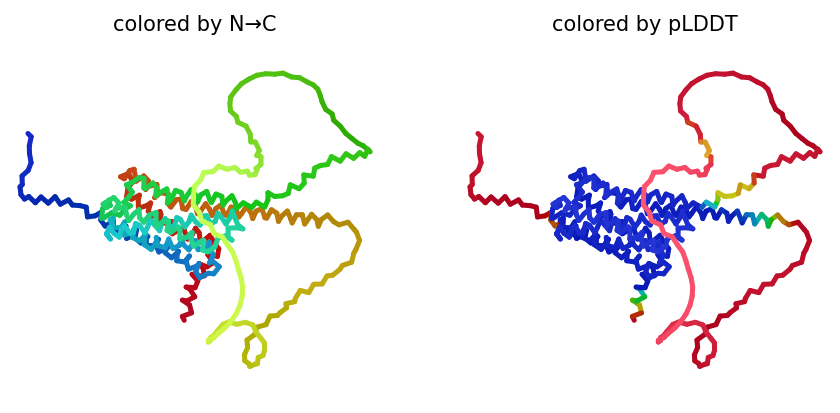

2024-10-21 11:17:57,916 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=75.9 pTM=0.688
2024-10-21 11:18:57,104 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=76.4 pTM=0.699 tol=6.15
2024-10-21 11:19:56,515 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=76.4 pTM=0.698 tol=2.25
2024-10-21 11:20:55,742 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=76.4 pTM=0.697 tol=1.21
2024-10-21 11:20:55,743 alphafold2_ptm_model_2_seed_000 took 237.0s (3 recycles)


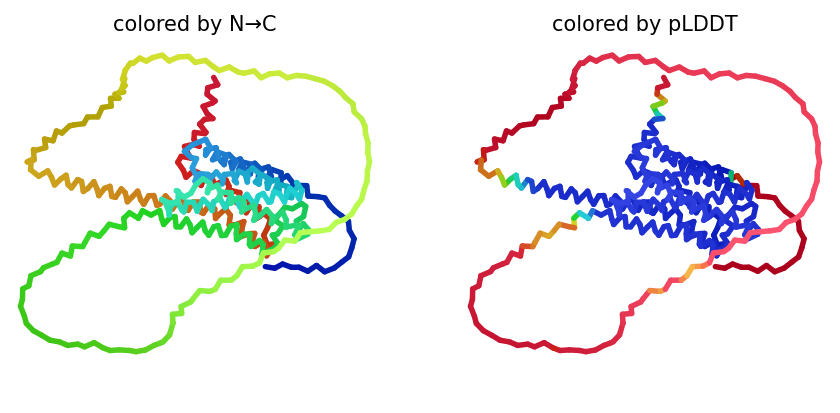

2024-10-21 11:20:56,324 reranking models by 'plddt' metric
2024-10-21 11:20:56,325 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=77.3 pTM=0.708
2024-10-21 11:20:56,326 rank_002_alphafold2_ptm_model_2_seed_000 pLDDT=76.4 pTM=0.697
2024-10-21 11:20:58,204 Done


0

In [118]:
#@title Run Prediction

import colabfold_runner

results = colabfold_runner.run(
    queries=queries,
    result_dir=result_dir,
    protein_family=protein_family,
    conformational_state=conformational_state,
    use_templates=use_templates,
    custom_template_path=None,
    use_amber=use_amber,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    model_order=[1, 2],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
)

results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

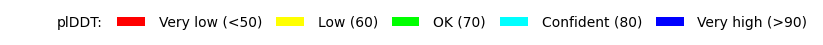

In [119]:
#@title Display 3D structure {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
rank_num = 1 #@param ["1", "2"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show()


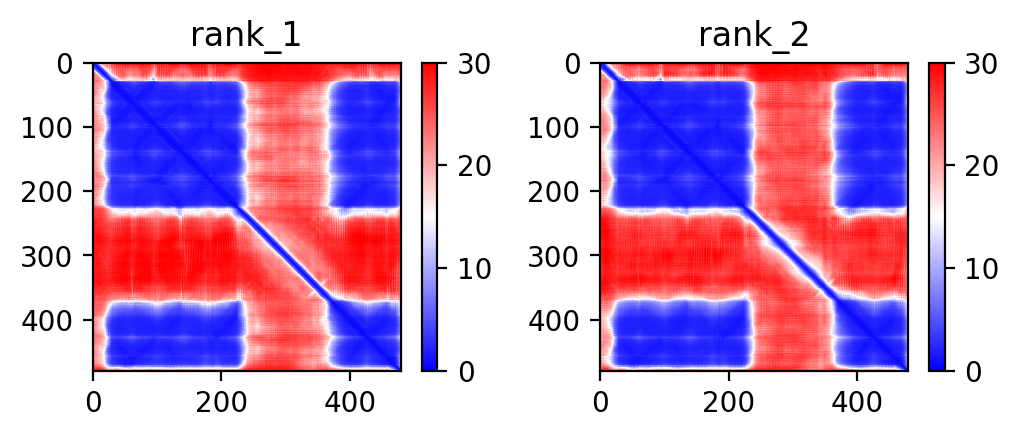
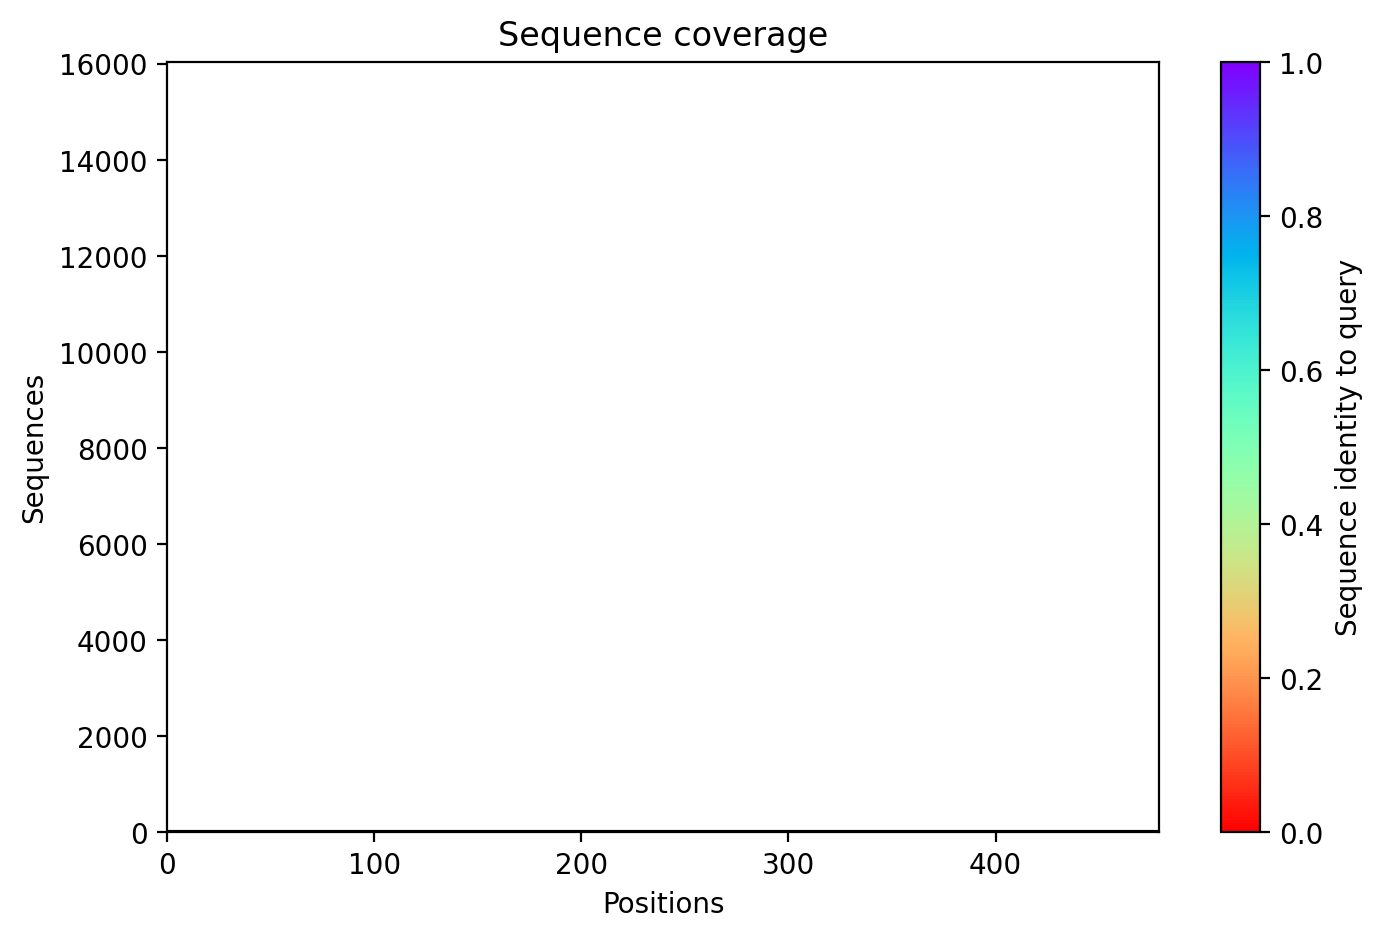
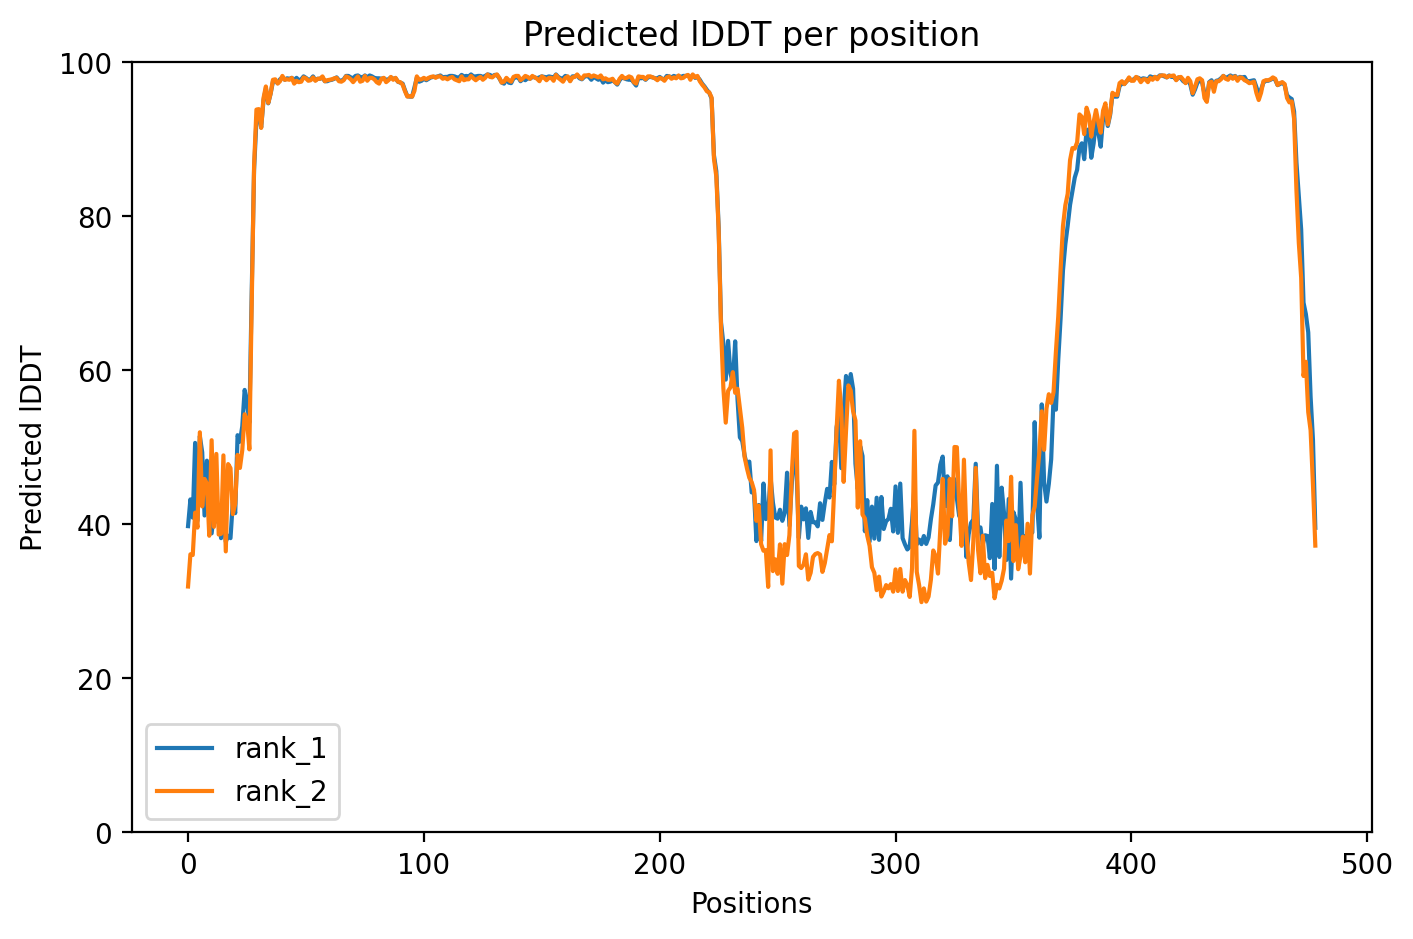

In [120]:
#@title Plots {run: "auto"}
from IPython.display import display, HTML
import base64
from html import escape

# see: https://stackoverflow.com/a/53688522
def image_to_data_url(filename):
  ext = filename.split('.')[-1]
  prefix = f'data:image/{ext};base64,'
  with open(filename, 'rb') as f:
    img = f.read()
  return prefix + base64.b64encode(img).decode('utf-8')

pae = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_pae.png"))
cov = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_coverage.png"))
plddt = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_plddt.png"))
display(HTML(f"""
<style>
  img {{
    float:left;
  }}
  .full {{
    max-width:100%;
  }}
  .half {{
    max-width:50%;
  }}
  @media (max-width:640px) {{
    .half {{
      max-width:100%;
    }}
  }}
</style>
<div style="max-width:90%; padding:2em;">
  <h1>Plots for {escape(jobname)}</h1>
  <img src="{pae}" class="full" />
  <!--img src="{cov}" class="half" /-->
  <img src="{plddt}" class="half" />
</div>
"""))


In [121]:
#@title Package and download results
#@markdown If you are having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).


if msa_mode == "custom":
  print("Don't forget to cite your custom MSA generation method.")

files.download(f"{jobname}.result.zip")

if save_to_google_drive == True and drive:
  uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
  uploaded.SetContentFile(f"{jobname}.result.zip")
  uploaded.Upload()
  print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Instructions <a name="Instructions"></a>
This Colab notebook is mostly based on [ColabFold](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb). We (Lim Heo and Michael Feig) slightly modified the notebook for multi-state modeling of the GPCR.


**Quick start**
1. Paste your protein sequence(s) in the input field.
2. Specify the **activation state** for modeling.
3. Press "Runtime" -> "Run all".

**Result zip file contents**
1. PDB formatted structures sorted by avg. pIDDT and complexes are sorted by pTMscore. (unrelaxed and relaxed if `use_amber` is enabled).
2. Plots of the model quality.
3. Plots of the MSA coverage.
4. Parameter log file.
5. A3M formatted input MSA.
6. BibTeX file with citations for all used tools and databases.

At the end of the job a download modal box will pop up with a `jobname.result.zip` file. Additionally, if the `save_to_google_drive` option was selected, the `jobname.result.zip` will be uploaded to your Google Drive.

**Troubleshooting**
* Check that the runtime type is set to GPU at "Runtime" -> "Change runtime type".
* Try to restart the session "Runtime" -> "Factory reset runtime".
* Check your input sequence.

**Known issues**
* If a prediction failed at the step of "Run Prediction", it is usually because of incompatibilities between dependent libraries including dm-haiku and jax, which are actively developed. If you encounter any errors, please let us know at huhlim@gmail.com or https://github.com/huhlim/alphafold-multistate/issues.
* Google Colab assigns different types of GPUs with varying amount of memory. Some might not have enough memory to predict the structure for a long sequence.
* Your browser can block the pop-up for downloading the result file. You can choose the `save_to_google_drive` option to upload to Google Drive instead or manually download the result file: Click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

**Limitations**
* Computing resources: MMseqs2 API can handle ~20-50k requests per day.
* MSAs: MMseqs2 is very precise and sensitive but might find less hits compared to HHblits/HMMer searched against BFD or Mgnify.

**Description of the plots**
*   **Predicted lDDT per position** - model confidence (out of 100) at each position. The higher the better.
*   **Predicted Alignment Error** - For homooligomers, this could be a useful metric to assess how confident the model is about the interface. The lower the better.


**Acknowledgments**
- [DeepMind](https://github.com/deepmind/alphafold) for the development and sharing the excellent protein structure prediction method, AlphaFold2.
- [ColabFold](https://github.com/sokrypton/ColabFold) for providing the valuable interface for running AlphaFold.
- [KOBIC](https://kobic.re.kr) and [Söding Lab](https://www.mpinat.mpg.de/soeding) for providing the computational resources for the MMseqs2 MSA server.


